# Notebook exploratoire ‚Äî classification des "passoires √©nerg√©tiques"

Objectif : guider l'exploration du jeu de donn√©es `logements_74.csv` en vue de construire ensuite un mod√®le de classification qui pr√©dit les "passoires √©nerg√©tiques" (√©tiquettes DPE faibles) et un mod√®le de r√©gression qui pr√©dit la consommation √©nerg√©tique.

Note : on d√©finit une *passoire √©nerg√©tique* si l'`etiquette_dpe` est `F` ou `G` (d√©finition courante en France).

In [52]:
# Imports et param√®tres d'affichage
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", context="notebook")
%matplotlib inline

In [53]:
# Chargement du fichier (chemin relatif) et v√©rification rapide
df = pd.read_csv("logements_74.csv", low_memory=False)
print('Shape :', df.shape)
display(df.head())

Shape : (203797, 236)


configuration_installation_chauffage_n1  \
0                   Installation de chauffage simple   
1  Installation de chauffage avec insert ou po√™le...   
2                   Installation de chauffage simple   
3                   Installation de chauffage simple   
4                   Installation de chauffage simple   

   conso_chauffage_installation_chauffage_n1  \
0                                     7540.8   
1                                    31616.6   
2                                     5909.3   
3                                     2511.8   
4                                     5088.3   

                           type_generateur_n1_ecs_n1 numero_voie_ban  \
0        Ballon √©lectrique √† accumulation horizontal             209   
1                  Chaudi√®re gaz classique 1986-1990              22   
2  Ballon √©lectrique √† accumulation vertical Cat√©...             NaN   
3            Chaudi√®re gaz √† condensation apr√®s 2015             NaN   
4             Chaudi√®re gaz √† condensation 2001-2015              11   

   score_ban  conso_auxiliaires_ep  deperditions_murs  cout_eclairage  \
0       0.86                2286.2               34.6            44.0   
1       0.95                3096.9               79.2            66.0   
2       0.39                1309.6              112.3            41.1   
3       0.66                 686.5                5.3            23.0   
4       0.59                1257.1               28.2            52.0   

   conso_auxiliaires_ef                                   statut_geocodage  \
0                 994.0                   adresse g√©ocod√©e ban √† l'adresse   
1                1346.5  adresse non g√©ocod√©e ban car aucune correspond...   
2                 569.4                   adresse g√©ocod√©e ban √† l'adresse   
3                 298.5                   adresse g√©ocod√©e ban √† l'adresse   
4                 546.6  adresse non g√©ocod√©e ban car aucune correspond...   

   ...  data_source  besoin_ecs_batiment  besoin_ecs_logement  \
0  ...     existant                  NaN                  NaN   
1  ...     existant                  NaN                  NaN   
2  ...     existant                  NaN                  NaN   
3  ...     existant                  NaN                  NaN   
4  ...     existant                  NaN                  NaN   

  deperditions_totales_logement  deperditions_totales_batiment  population  \
0                           NaN                            NaN         806   
1                           NaN                            NaN        2332   
2                           NaN                            NaN        1701   
3                           NaN                            NaN        2779   
4                           NaN                            NaN      131715   

  superficie_km2  densite  altitude_moyenne      grille_densite_texte  
0              9     91.0              1304        Ceintures urbaines  
1             11    203.0               776  Rural √† habitat dispers√©  
2             16    103.0               630  Rural √† habitat dispers√©  
3              9    323.0               487        Ceintures urbaines  
4             16   8258.0               554    Grands centres urbains  

[5 rows x 236 columns]

In [54]:
# Aper√ßu des types et des valeurs manquantes de base
display(df.info())
# R√©sum√© num√©rique succinct pour rep√©rer distributions et anomalies
display(df.select_dtypes(include=[np.number]).describe().T)

# Liste des colonnes disponibles (utile pour rep√©rer noms exacts)
print('\nNombre de colonnes :', len(df.columns))
print(df.columns.tolist()[:80])  # affiche les 80 premi√®res colonnes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203797 entries, 0 to 203796
Columns: 236 entries, configuration_installation_chauffage_n1 to grille_densite_texte
dtypes: float64(126), int64(11), object(99)
memory usage: 366.9+ MB


None

count          mean  \
conso_chauffage_installation_chauffage_n1  165582.0  44848.735200   
score_ban                                  203797.0      0.620668   
conso_auxiliaires_ep                       203792.0   1134.827294   
deperditions_murs                          170803.0    232.338079   
cout_eclairage                             203796.0     64.604740   
...                                             ...           ...   
deperditions_totales_batiment                4750.0    975.216863   
population                                 203797.0  32641.604984   
superficie_km2                             203797.0     23.135826   
densite                                    203797.0   2521.339078   
altitude_moyenne                           203797.0    742.394510   

                                                     std    min      25%  \
conso_chauffage_installation_chauffage_n1  148760.681372    1.0  3509.90   
score_ban                                       0.157200    0.0     0.51   
conso_auxiliaires_ep                         3839.084960    0.0   302.20   
deperditions_murs                             644.157817    0.0    15.00   
cout_eclairage                                731.701078    0.0    23.60   
...                                                  ...    ...      ...   
deperditions_totales_batiment                 563.749980  110.2   610.30   
population                                  47315.990469   51.0  2961.00   
superficie_km2                                 34.675663    1.0     9.00   
densite                                      3248.351503    5.0   186.00   
altitude_moyenne                              428.572355  335.0   471.00   

                                               50%        75%         max  
conso_chauffage_installation_chauffage_n1  6934.55  19931.925  2393909.40  
score_ban                                     0.60      0.700        0.98  
conso_auxiliaires_ep                        678.00   1172.300   245087.20  
deperditions_murs                            47.60    184.500    10102.30  
cout_eclairage                               35.80     51.000   297316.00  
...                                            ...        ...         ...  
deperditions_totales_batiment               855.10   1221.200     4138.90  
population                                 9059.00  37027.000   131715.00  
superficie_km2                               16.00     19.000      245.00  
densite                                     644.00   5096.000     8258.00  
altitude_moyenne                            554.00    790.000     2445.00  

[137 rows x 8 columns]


Nombre de colonnes : 236
['configuration_installation_chauffage_n1', 'conso_chauffage_installation_chauffage_n1', 'type_generateur_n1_ecs_n1', 'numero_voie_ban', 'score_ban', 'conso_auxiliaires_ep', 'deperditions_murs', 'cout_eclairage', 'conso_auxiliaires_ef', 'statut_geocodage', 'ventilation_posterieure_2012', 'cout_chauffage', 'conso_5_usages_par_m2_ep', 'date_etablissement_dpe', 'conso_ecs_ef_energie_n1', 'emission_ges_chauffage', 'description_installation_chauffage_n1', 'conso_5_usages_par_m2_ef', 'conso_chauffage_ef_energie_n1', 'presence_brasseur_air', 'qualite_isolation_menuiseries', 'date_reception_dpe', 'cout_total_5_usages_energie_n1', 'cout_ecs_energie_n1', 'isolation_toiture', 'modele_dpe', 'qualite_isolation_enveloppe', 'conso_chauffage_generateur_n1_installation_n1', 'type_energie_n1', 'emission_ges_eclairage', 'code_postal_ban', 'emission_ges_ecs', 'conso_5_usages_ef', 'conso_5_usages_ef_energie_n1', 'code_insee_ban', 'deperditions_planchers_bas', 'conso_5_usages_ep', 

### D√©finition de la cible (et cr√©ation d'une colonne binaire `passoire`)

Nous partons de l'hypoth√®se suivante : `passoire` = True si `etiquette_dpe` est `F` ou `G`.

In [55]:
# Standardiser l'orthographe et cr√©er la cible
df['etiquette_dpe'] = df['etiquette_dpe'].astype(str).str.strip().str.upper().replace({'NAN': np.nan, 'NONE': np.nan})
# D√©finition: F ou G => passoire
df['passoire'] = df['etiquette_dpe'].isin(['F','G']).astype(int)
print('Distribution de la cible (passoire=1):')
display(df['passoire'].value_counts(dropna=False))
display(df['etiquette_dpe'].value_counts(dropna=False).head(20))

Distribution de la cible (passoire=1):


passoire
0    173800
1     29997
Name: count, dtype: int64

etiquette_dpe
C    72953
D    49005
E    39969
F    17576
G    12421
B     7403
A     4470
Name: count, dtype: int64

### Valeurs manquantes ‚Äî colonne par colonne (pour prioriser le nettoyage)

On calcule le pourcentage de valeurs manquantes et on affiche les colonnes les plus affect√©es.

In [56]:
missing = df.isna().mean().sort_values(ascending=False)
display(missing.head(60))
# Colonnes avec moins de 5% de manquants ‚Äî candidates faciles pour mod√©lisation rapide
display(missing[missing < 0.05].sort_values())


_score                                                        1.000000
description_generateur_n2_ecs_n1                              0.999995
facteur_couverture_solaire_saisi_installation_chauffage_n2    0.999990
facteur_couverture_solaire_installation_chauffage_n2          0.999912
conso_ef_generateur_n2_ecs_n1                                 0.999872
type_energie_generateur_n2_ecs_n1                             0.999868
type_generateur_n2_ecs_n1                                     0.999868
usage_generateur_n2_ecs_n1                                    0.999868
volume_stockage_generateur_n2_ecs_n1                          0.999868
date_installation_generateur_n2_ecs_n1                        0.999868
facteur_couverture_solaire_saisi_installation_chauffage_n1    0.999818
facteur_couverture_solaire_installation_chauffage_n1          0.999171
surface_tertiaire_immeuble                                    0.998778
facteur_couverture_solaire_saisi_n1                           0.998194
nombre

densite                            0.000000
_id                                0.000000
code_postal_brut                   0.000000
conso_refroidissement_ep           0.000000
coordonnee_cartographique_y_ban    0.000000
                                     ...   
adresse_ban                        0.000093
qualite_isolation_murs             0.000118
surface_habitable_logement         0.027606
nom_rue_ban                        0.035683
qualite_isolation_plancher_bas     0.046463
Length: 86, dtype: float64

### V√©rification rapide des coordonn√©es g√©ographiques (si pr√©sentes)

Si `coordonnee_cartographique_x_ban` et `coordonnee_cartographique_y_ban` existent et sont valides, on peut v√©rifier une dispersion sommaire pour d√©tecter anomalies (ex : 0/NaN).

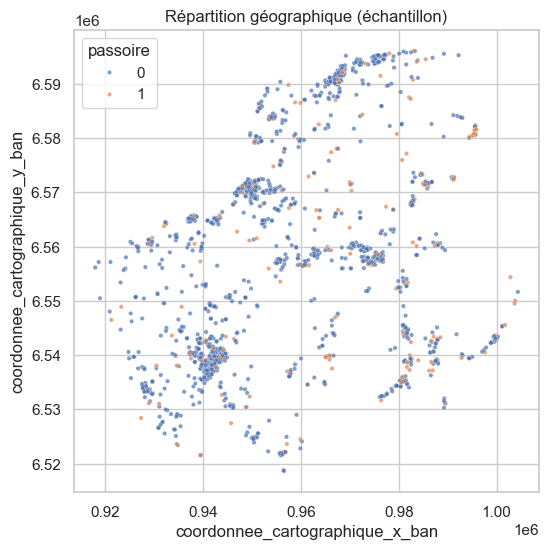

In [57]:
lat_col = 'coordonnee_cartographique_y_ban'
lon_col = 'coordonnee_cartographique_x_ban'
if lat_col in df.columns and lon_col in df.columns:
    sub = df[[lon_col, lat_col, 'passoire']].dropna().sample(min(2000, len(df.dropna(subset=[lon_col, lat_col]))))
    plt.figure(figsize=(6,6))
    sns.scatterplot(data=sub, x=lon_col, y=lat_col, hue='passoire', s=10, alpha=0.7)
    plt.title('R√©partition g√©ographique (√©chantillon)')
    plt.show()
else:
    print('Colonnes de coordonn√©es non trouv√©es ou manquantes dans le dataset.')


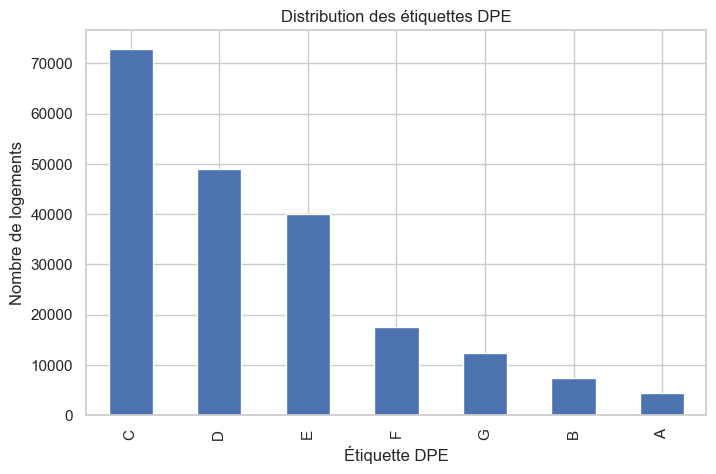

In [58]:
df['etiquette_dpe'].value_counts().plot(kind='bar', figsize=(8,5), title='Distribution des √©tiquettes DPE')
plt.xlabel('√âtiquette DPE') 
plt.ylabel('Nombre de logements')
plt.show()

## Partie 1 : Pr√©paration des donn√©es et identification des variables cibles

### 1.1 Identification de la variable de consommation √©lectrique

Nous allons d'abord identifier les colonnes li√©es √† la consommation √©lectrique pour notre mod√®le de r√©gression.

In [59]:
# Recherche des colonnes li√©es √† la consommation
conso_cols = [col for col in df.columns if 'conso' in col.lower()]
print('Colonnes de consommation disponibles:')
for col in conso_cols:
    print(f"  - {col}")
    
# Afficher statistiques pour les colonnes de consommation num√©riques
print('\n--- Statistiques des colonnes de consommation ---')
for col in conso_cols:
    if df[col].dtype in ['float64', 'int64']:
        print(f"\n{col}:")
        print(f"  Valeurs manquantes: {df[col].isna().sum()} ({df[col].isna().mean()*100:.2f}%)")
        print(f"  Min: {df[col].min():.2f}, Max: {df[col].max():.2f}, Moyenne: {df[col].mean():.2f}")

Colonnes de consommation disponibles:
  - conso_chauffage_installation_chauffage_n1
  - conso_auxiliaires_ep
  - conso_auxiliaires_ef
  - conso_5_usages_par_m2_ep
  - conso_ecs_ef_energie_n1
  - conso_5_usages_par_m2_ef
  - conso_chauffage_ef_energie_n1
  - conso_chauffage_generateur_n1_installation_n1
  - conso_5_usages_ef
  - conso_5_usages_ef_energie_n1
  - conso_5_usages_ep
  - conso_chauffage_ef
  - conso_ecs_ep
  - conso_ecs_ef
  - conso_ef_installation_ecs_n1
  - conso_refroidissement_ef
  - conso_eclairage_ef
  - conso_ef_generateur_n1_ecs_n1
  - conso_chauffage_ep
  - conso_eclairage_ep
  - conso_refroidissement_ep
  - conso_ecs_ef_energie_n3
  - conso_ecs_ef_energie_n2
  - conso_chauffage_ef_energie_n2
  - conso_chauffage_ef_energie_n3
  - conso_5_usages_ef_energie_n3
  - conso_5_usages_ef_energie_n2
  - conso_chauffage_generateur_n2_installation_n1
  - conso_chauffage_generateur_n1_installation_n2
  - conso_chauffage_installation_chauffage_n2
  - conso_refroidissement_annuel

### 1.2 Identification des variables explicatives pertinentes

Nous allons identifier les variables potentiellement importantes pour nos mod√®les :
- Variables g√©ographiques (zone climatique, altitude, coordonn√©es)
- Caract√©ristiques du logement (surface, ann√©e de construction, isolation, etc.)
- Caract√©ristiques √©nerg√©tiques (type de chauffage, isolation, etc.)

In [60]:
# Recherche de colonnes cl√©s pour l'analyse
keywords = {
    'g√©ographique': ['altitude', 'zone', 'climat', 'region', 'coordonnee'],
    'logement': ['surface', 'annee', 'construction', 'niveau', 'hauteur'],
    'isolation': ['isolation', 'menuiserie', 'mur', 'toiture', 'plancher', 'enveloppe'],
    'chauffage': ['chauffage', 'generateur', 'energie', 'emetteur'],
    'ecs': ['ecs', 'eau_chaude'],
    'dpe': ['dpe', 'etiquette', 'classe', 'emission', 'ges']
}

print("=== Variables disponibles par cat√©gorie ===\n")
variables_interessantes = []
for categorie, mots_cles in keywords.items():
    cols = []
    for mot in mots_cles:
        cols.extend([c for c in df.columns if mot.lower() in c.lower() and c not in cols])
    print(f"\n{categorie.upper()} ({len(cols)} colonnes):")
    for col in cols[:15]:  # Limite √† 15 pour lisibilit√©
        variables_interessantes.append(col)
        taux_manquant = df[col].isna().mean() * 100
        print(f"  - {col} (manquants: {taux_manquant:.1f}%)")

=== Variables disponibles par cat√©gorie ===


G√âOGRAPHIQUE (8 colonnes):
  - classe_altitude (manquants: 10.9%)
  - altitude_moyenne (manquants: 0.0%)
  - zone_climatique (manquants: 10.9%)
  - type_energie_climatisation (manquants: 98.4%)
  - surface_climatisee (manquants: 98.3%)
  - code_region_ban (manquants: 0.0%)
  - coordonnee_cartographique_x_ban (manquants: 0.0%)
  - coordonnee_cartographique_y_ban (manquants: 0.0%)

LOGEMENT (14 colonnes):
  - surface_chauffee_installation_chauffage_n1 (manquants: 18.8%)
  - surface_habitable_desservie_par_installation_ecs_n1 (manquants: 18.9%)
  - surface_habitable_logement (manquants: 2.8%)
  - surface_chauffee_installation_chauffage_n2 (manquants: 85.4%)
  - surface_climatisee (manquants: 98.3%)
  - surface_habitable_immeuble (manquants: 36.1%)
  - surface_ventilee (manquants: 96.5%)
  - surface_totale_capteurs_pv (manquants: 99.3%)
  - surface_tertiaire_immeuble (manquants: 99.9%)
  - annee_construction (manquants: 42.6%)
  - periode_con

## Partie 2 : Pr√©traitement et s√©lection des features

### 2.1 Pr√©paration du dataset pour la mod√©lisation

Nous allons :
1. S√©parer les variables num√©riques et cat√©gorielles
2. G√©rer les valeurs manquantes
3. Cr√©er un ensemble de features potentielles

In [61]:
# Imports suppl√©mentaires pour la mod√©lisation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression, f_classif, mutual_info_regression, mutual_info_classif, RFE
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, classification_report, confusion_matrix, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [62]:
# D√©finir la cible pour la r√©gression (consommation √©lectrique)
# Choisissons une variable de consommation appropri√©e
target_regression = 'conso_5_usages_ep'  # Consommation 5 usages en √©nergie primaire

# V√©rifier la disponibilit√© de la cible
print(f"Target r√©gression : {target_regression}")
print(f"Valeurs manquantes : {df[target_regression].isna().sum()} ({df[target_regression].isna().mean()*100:.2f}%)")
print(f"Statistiques :\n{df[target_regression].describe()}")

# Cr√©er un dataframe de travail sans les lignes o√π la cible est manquante
df_work = df[df[target_regression].notna() & df['passoire'].notna()].copy()
print(f"\nDataset de travail : {df_work.shape}")

Target r√©gression : conso_5_usages_ep
Valeurs manquantes : 5 (0.00%)
Statistiques :
count    2.037920e+05
mean     2.164666e+04
std      5.589591e+04
min      3.141000e+02
25%      6.977575e+03
50%      1.131610e+04
75%      1.956080e+04
max      5.957086e+06
Name: conso_5_usages_ep, dtype: float64

Dataset de travail : (203792, 237)

Dataset de travail : (203792, 237)


In [63]:
# S√©lectionner les colonnes potentiellement utiles
# On exclut les colonnes li√©es √† la cible (consommation, √©mission, DPE, co√ªts)
# ET les calculs interm√©diaires du DPE (besoins, d√©perditions) qui sont des fuites
colonnes_a_exclure = ['conso', 'emission', 'cout', 'etiquette_dpe', 'etiquette_ges',
                      'date_', 'passoire', '_rand', '_geopoint',
                      'besoin_', 'deperdition',  # Calculs interm√©diaires DPE
                      'methode_application_dpe', 'modele_dpe',  # Variables administratives/techniques DPE
                      'surface_chauffee_installation_chauffage_n1',  # VIF > 10 (multicolin√©arit√©)
                      'surface_habitable_desservie_par_installation_ecs_n1']  # VIF > 10 (multicolin√©arit√©)

# Cr√©er liste des features candidates
features_candidates = []
for col in df_work.columns:
    # Exclure les colonnes li√©es aux r√©sultats
    if not any(exclu in col.lower() for exclu in colonnes_a_exclure):
        features_candidates.append(col)

print(f"Nombre de features candidates : {len(features_candidates)}")
print(f"\nPremi√®res features : {features_candidates[:20]}")

Nombre de features candidates : 141

Premi√®res features : ['configuration_installation_chauffage_n1', 'type_generateur_n1_ecs_n1', 'numero_voie_ban', 'score_ban', 'statut_geocodage', 'ventilation_posterieure_2012', 'description_installation_chauffage_n1', 'presence_brasseur_air', 'qualite_isolation_menuiseries', 'isolation_toiture', 'qualite_isolation_enveloppe', 'type_energie_n1', 'code_postal_ban', 'code_insee_ban', 'code_region_ban', 'volume_stockage_generateur_n1_ecs_n1', 'version_dpe', 'coordonnee_cartographique_x_ban', 'type_generateur_chauffage_principal', 'type_energie_principale_ecs']


In [64]:
# S√©parer variables num√©riques et cat√©gorielles
numeric_features = []
categorical_features = []

for col in features_candidates:
    if df_work[col].dtype in ['float64', 'int64']:
        # V√©rifier si pas trop de valeurs manquantes (< 50%)
        if df_work[col].isna().mean() < 0.5:
            numeric_features.append(col)
    elif df_work[col].dtype == 'object':
        # Pour les cat√©gorielles, garder celles avec peu de modalit√©s et peu de manquants
        n_unique = df_work[col].nunique()
        if n_unique < 50 and df_work[col].isna().mean() < 0.5:
            categorical_features.append(col)

print(f"Variables num√©riques s√©lectionn√©es : {len(numeric_features)}")
print(f"Variables cat√©gorielles s√©lectionn√©es : {len(categorical_features)}")
print(f"\nExemples de variables num√©riques : {numeric_features[:10]}")
print(f"\nExemples de variables cat√©gorielles : {categorical_features[:10]}")

Variables num√©riques s√©lectionn√©es : 35
Variables cat√©gorielles s√©lectionn√©es : 29

Exemples de variables num√©riques : ['score_ban', 'ventilation_posterieure_2012', 'presence_brasseur_air', 'isolation_toiture', 'code_postal_ban', 'code_insee_ban', 'code_region_ban', 'volume_stockage_generateur_n1_ecs_n1', 'version_dpe', 'coordonnee_cartographique_x_ban']

Exemples de variables cat√©gorielles : ['configuration_installation_chauffage_n1', 'statut_geocodage', 'qualite_isolation_menuiseries', 'qualite_isolation_enveloppe', 'type_energie_n1', 'type_energie_principale_ecs', 'type_installation_chauffage', 'type_installation_ecs_n1', 'type_emetteur_installation_chauffage_n1', 'configuration_installation_ecs_n1']


### Analyse approfondie de la s√©lection des variables

Avant de proc√©der √† la s√©lection automatique, nous allons analyser en d√©tail la pertinence des variables selon les meilleures pratiques :

1. **V√©rification des variables cl√©s recommand√©es** (structure, isolation, chauffage, ECS, climat)
2. **Analyse des corr√©lations** avec la cible (r√©gression)
3. **Tests statistiques Chi-2** pour les variables cat√©gorielles (classification)
4. **D√©tection de la multicolin√©arit√©** (VIF)

In [65]:
# ========================================
# 1. V√âRIFICATION DES VARIABLES CL√âS RECOMMAND√âES
# ========================================

variables_cles = {
    'structure': ['surface_habitable', 'nombre_niveau', 'hauteur_sous_plafond', 
                  'periode_construction', 'annee_construction', 'volume_stockage', 'type_batiment',
                  'numero_etage', 'logement_traversant'],
    'isolation': ['qualite_isolation_enveloppe', 'qualite_isolation_murs', 
                  'qualite_isolation_menuiseries', 'qualite_isolation_plancher_bas',
                  'qualite_isolation_plancher_haut', 'ubat', 'deperdition'],
    'chauffage': ['type_generateur_chauffage', 'type_energie_principale_chauffage',
                  'type_emetteur', 'besoin_chauffage', 'type_installation_chauffage'],
    'ecs': ['type_generateur_n1_ecs', 'type_energie_principale_ecs', 'besoin_ecs'],
    'climat': ['zone_climatique', 'classe_altitude', 'altitude_moyenne', 'altitude'],
    'ventilation': ['type_ventilation', 'classe_inertie', 'indicateur_confort']
}

print("="*80)
print("VARIABLES CL√âS RECOMMAND√âES - PR√âSENCE ET QUALIT√â")
print("="*80)

variables_trouvees = {}

for categorie, vars_list in variables_cles.items():
    print(f"\n{'‚îÄ'*80}")
    print(f"{categorie.upper()}")
    print(f"{'‚îÄ'*80}")
    
    variables_trouvees[categorie] = []
    
    for var_pattern in vars_list:
        matching = [c for c in df_work.columns if var_pattern.lower() in c.lower() 
                   and not any(exclu in c.lower() for exclu in ['conso', 'emission', 'cout', 'etiquette'])]
        
        if matching:
            for var in matching:
                missing_pct = df_work[var].isna().mean() * 100
                dtype = df_work[var].dtype
                n_unique = df_work[var].nunique() if dtype == 'object' else '-'
                
                status = "‚úì" if missing_pct < 50 else "‚ö†"
                print(f"  {status} {var:50s} | Manquants: {missing_pct:5.1f}% | Type: {str(dtype):10s} | Modalit√©s: {n_unique}")
                
                if missing_pct < 50:  # Garder seulement si < 50% de manquants
                    variables_trouvees[categorie].append(var)
        else:
            print(f"  ‚úó Pattern '{var_pattern}' non trouv√©")

print(f"\n{'='*80}")
print(f"R√âSUM√â: {sum(len(v) for v in variables_trouvees.values())} variables cl√©s disponibles")
print(f"{'='*80}")

VARIABLES CL√âS RECOMMAND√âES - PR√âSENCE ET QUALIT√â

‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
STRUCTURE
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
  ‚úì surface_habitable_desservie_par_installation_ecs_n1 | Manquants:  18.9% | Type: float64    | Modalit√©s: -
  ‚úì surface_habitable_logement                         | Manquants:   2.8% | Type: float64    | Modalit√©s: -
  ‚úì surface_habitable_immeuble                         | Manquants:  36.1% | Type: float64    | Modalit√©s: -
  ‚úì nombre_niveau_logement                             | Manquants:   6.5% | Type: float64    | Modalit√©s: -
  ‚ö


TOP CORR√âLATIONS AVEC LA CONSOMMATION √âLECTRIQUE

Top 30 corr√©lations (valeur absolue) :
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
 1. surface_habitable_logement                         | r = +0.7125 (‚Üë Positive)
 2. surface_ventilee                                   | r = +0.5977 (‚Üë Positive)
 3. volume_stockage_generateur_n2_ecs_n1               | r = +0.4043 (‚Üë Positive)
 4. logement_traversant                                | r = +0.2789 (‚Üë Positive)
 5. apport_interne_saison_chauffe                      | r = +0.2728 (‚Üë Positive)
 6. facteur_couverture_solaire_installation_chauffage_n2 | r = -0.2535 (‚Üì N√©gative)
 7. surface_climatisee                                 | r = +0.2378 (‚Üë Positive)
 8. apport_solaire_saison_chauffe                      | r = +0.2197 (‚Üë P

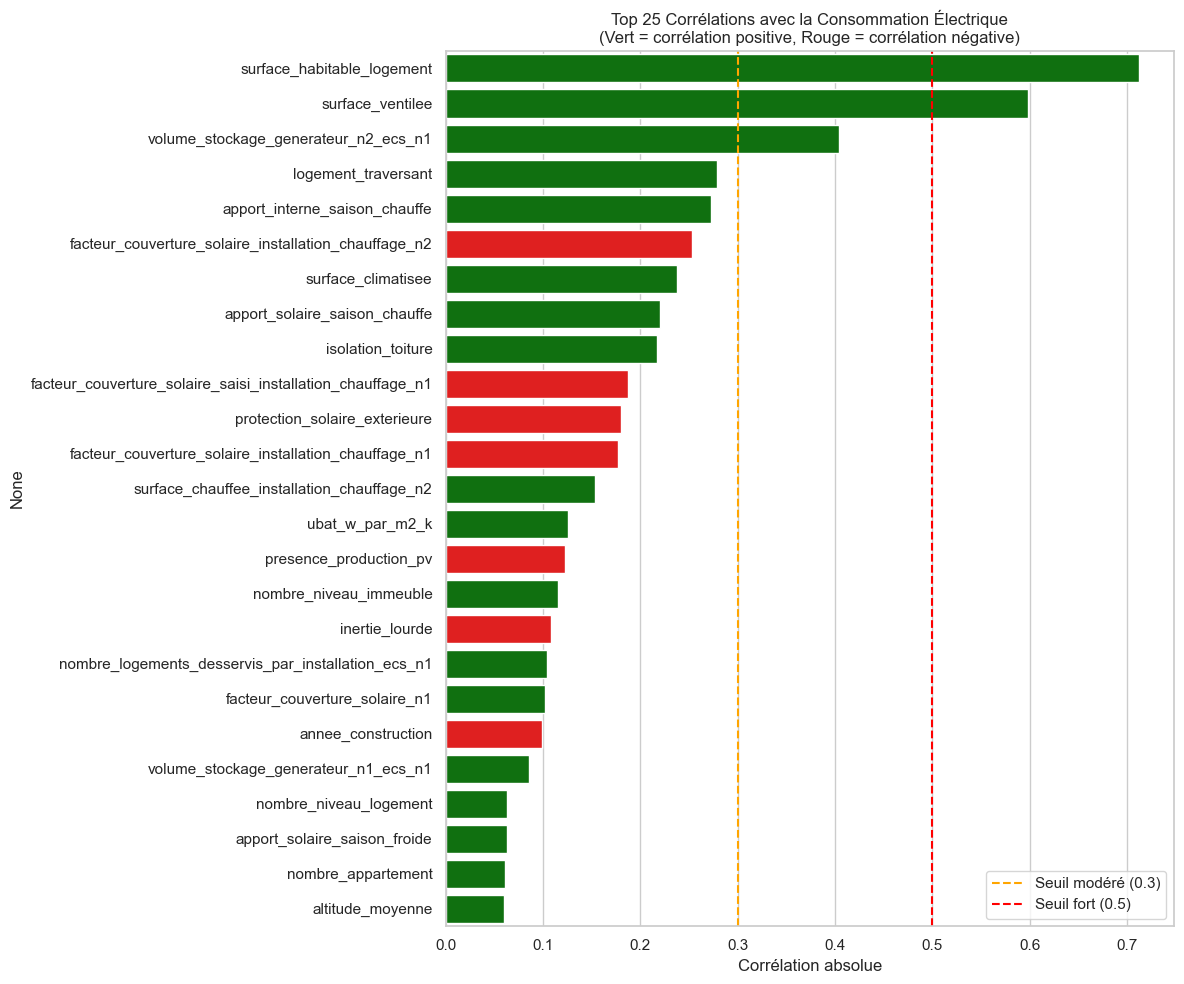


‚úì Variables avec corr√©lation > 0.3: 3
‚úì Variables avec corr√©lation > 0.5: 2


In [66]:
# ========================================
# 2. CORR√âLATIONS AVEC LA CIBLE (R√âGRESSION)
# ========================================

print("\n" + "="*80)
print("TOP CORR√âLATIONS AVEC LA CONSOMMATION √âLECTRIQUE")
print("="*80)

# Identifier les colonnes num√©riques (excluant les fuites de donn√©es)
numeric_cols_for_corr = [c for c in df_work.select_dtypes(include=[np.number]).columns 
                         if not any(exclu in c.lower() for exclu in ['conso', 'emission', 'cout', 'etiquette_dpe', 'etiquette_ges',
                                                                       'passoire', 'besoin_', 'deperdition',
                                                                       'methode_application_dpe', 'modele_dpe',
                                                                       'surface_chauffee_installation_chauffage_n1',
                                                                       'surface_habitable_desservie_par_installation_ecs_n1'])]  # Exclusion calculs DPE + variables admin + VIF > 10

# Calculer les corr√©lations avec la cible
correlations = df_work[numeric_cols_for_corr].corrwith(df_work[target_regression]).abs().sort_values(ascending=False)

# Afficher les top 30
print("\nTop 30 corr√©lations (valeur absolue) :")
print("‚îÄ"*80)
for i, (var, corr) in enumerate(correlations.head(30).items(), 1):
    corr_signed = df_work[var].corr(df_work[target_regression])
    direction = "‚Üë Positive" if corr_signed > 0 else "‚Üì N√©gative"
    print(f"{i:2d}. {var:50s} | r = {corr_signed:+.4f} ({direction})")

# Visualisation
plt.figure(figsize=(12, 10))
top_corr = correlations.head(25)
colors = ['green' if df_work[var].corr(df_work[target_regression]) > 0 else 'red' 
          for var in top_corr.index]
sns.barplot(x=top_corr.values, y=top_corr.index, palette=colors)
plt.title('Top 25 Corr√©lations avec la Consommation √âlectrique\n(Vert = corr√©lation positive, Rouge = corr√©lation n√©gative)')
plt.xlabel('Corr√©lation absolue')
plt.axvline(x=0.3, color='orange', linestyle='--', label='Seuil mod√©r√© (0.3)')
plt.axvline(x=0.5, color='red', linestyle='--', label='Seuil fort (0.5)')
plt.legend()
plt.tight_layout()
plt.show()

print(f"\n‚úì Variables avec corr√©lation > 0.3: {(correlations > 0.3).sum()}")
print(f"‚úì Variables avec corr√©lation > 0.5: {(correlations > 0.5).sum()}")


TEST CHI-2 POUR LA PR√âDICTION DES PASSOIRES √âNERG√âTIQUES

Analyse de 29 variables cat√©gorielles...

Top 20 variables cat√©gorielles les plus discriminantes :
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
qualite_isolation_enveloppe                        | Chi2 =   20033.54 | p-value = 0.00e+00 ***
configuration_installation_ecs_n1                  | Chi2 =   11331.49 | p-value = 0.00e+00 ***
zone_climatique                                    | Chi2 =   10567.75 | p-value = 0.00e+00 ***
periode_construction                               | Chi2 =   10349.45 | p-value = 0.00e+00 ***
type_energie_generateur_n1_installation_n1         | Chi2 =   10299.21 | p-value = 0.00e+00 ***
type_installation_solaire_n1                       | Chi2 =    7886.34 | p-value = 0.00e+00 ***
qualite_isolation_mu

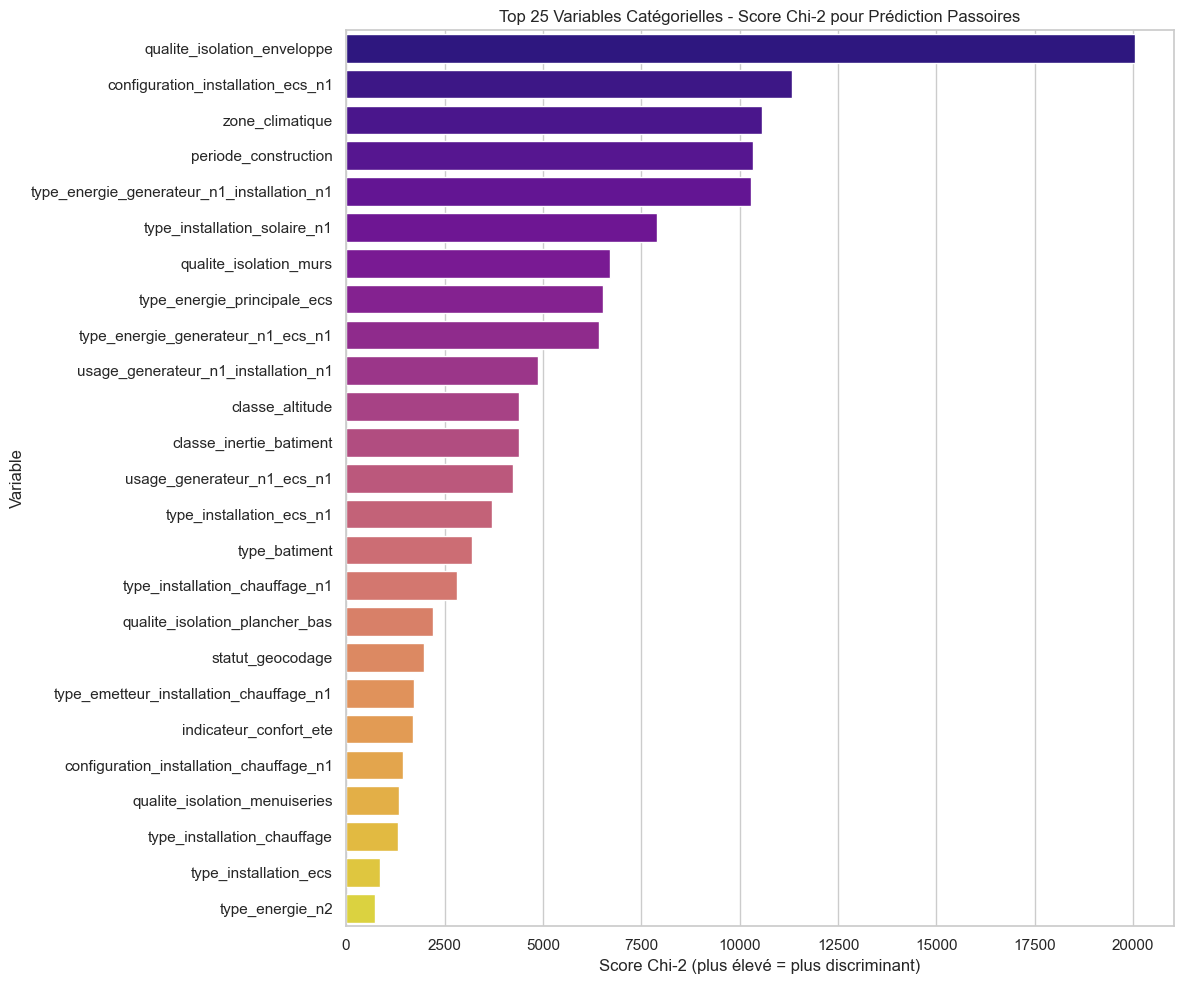


‚úì Variables significatives (p < 0.05): 27
‚úì Variables tr√®s significatives (p < 0.001): 27


In [67]:
# ========================================
# 3. TEST CHI-2 POUR VARIABLES CAT√âGORIELLES (CLASSIFICATION)
# ========================================

from sklearn.feature_selection import chi2

print("\n" + "="*80)
print("TEST CHI-2 POUR LA PR√âDICTION DES PASSOIRES √âNERG√âTIQUES")
print("="*80)

# Encoder les variables cat√©gorielles pour le test Chi-2
categorical_for_chi2 = [col for col in categorical_features if col in df_work.columns]

if len(categorical_for_chi2) > 0:
    print(f"\nAnalyse de {len(categorical_for_chi2)} variables cat√©gorielles...\n")
    
    # Encoder les cat√©gorielles (factorize convertit en entiers)
    categorical_encoded = pd.DataFrame()
    for col in categorical_for_chi2:
        categorical_encoded[col] = pd.factorize(df_work[col].fillna('MISSING'))[0]
    
    # Test Chi-2
    chi2_scores, p_values = chi2(categorical_encoded, df_work['passoire'])
    
    # Cr√©er un DataFrame des r√©sultats
    chi2_df = pd.DataFrame({
        'Variable': categorical_for_chi2,
        'Chi2_Score': chi2_scores,
        'P_Value': p_values
    }).sort_values('Chi2_Score', ascending=False)
    
    # Afficher les top 20
    print("Top 20 variables cat√©gorielles les plus discriminantes :")
    print("‚îÄ"*80)
    for i, row in chi2_df.head(20).iterrows():
        significance = "***" if row['P_Value'] < 0.001 else "**" if row['P_Value'] < 0.01 else "*" if row['P_Value'] < 0.05 else ""
        print(f"{row['Variable']:50s} | Chi2 = {row['Chi2_Score']:10.2f} | p-value = {row['P_Value']:.2e} {significance}")
    
    print("\n*** p < 0.001 (tr√®s significatif), ** p < 0.01, * p < 0.05")
    
    # Visualisation
    plt.figure(figsize=(12, 10))
    top_chi2 = chi2_df.head(25)
    sns.barplot(data=top_chi2, y='Variable', x='Chi2_Score', palette='plasma')
    plt.title('Top 25 Variables Cat√©gorielles - Score Chi-2 pour Pr√©diction Passoires')
    plt.xlabel('Score Chi-2 (plus √©lev√© = plus discriminant)')
    plt.tight_layout()
    plt.show()
    
    print(f"\n‚úì Variables significatives (p < 0.05): {(chi2_df['P_Value'] < 0.05).sum()}")
    print(f"‚úì Variables tr√®s significatives (p < 0.001): {(chi2_df['P_Value'] < 0.001).sum()}")
else:
    print("‚ö† Aucune variable cat√©gorielle disponible pour le test Chi-2")


D√âTECTION DE LA MULTICOLIN√âARIT√â (VIF - Variance Inflation Factor)

Crit√®res d'interpr√©tation :
  ‚Ä¢ VIF < 5   : Pas de multicolin√©arit√©
  ‚Ä¢ VIF 5-10  : Multicolin√©arit√© mod√©r√©e
  ‚Ä¢ VIF > 10  : Multicolin√©arit√© forte (variable redondante)

Calcul sur un √©chantillon de 5000 observations...
Analyse de 33 variables num√©riques...

Analyse de 33 variables num√©riques...

Variables avec FORTE multicolin√©arit√© (VIF > 10) :
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
‚úì Aucune variable avec VIF > 10

‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
Variables avec multicolin√©arit√© MOD√âR

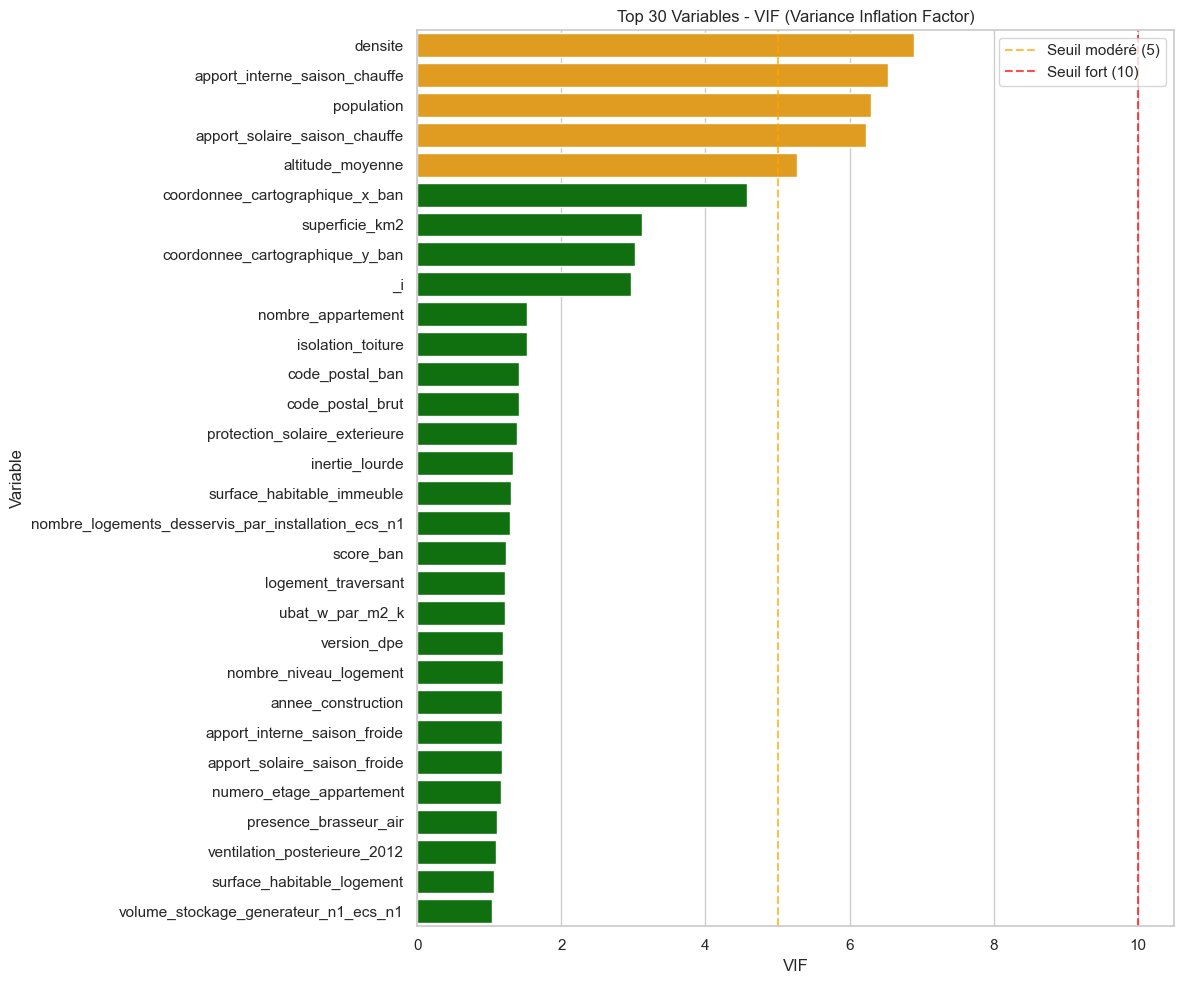


RECOMMANDATIONS
‚úì Pas de probl√®me majeur de multicolin√©arit√©


In [68]:
# ========================================
# 4. D√âTECTION DE LA MULTICOLIN√âARIT√â (VIF)
# ========================================

from statsmodels.stats.outliers_influence import variance_inflation_factor

print("\n" + "="*80)
print("D√âTECTION DE LA MULTICOLIN√âARIT√â (VIF - Variance Inflation Factor)")
print("="*80)

print("\nCrit√®res d'interpr√©tation :")
print("  ‚Ä¢ VIF < 5   : Pas de multicolin√©arit√©")
print("  ‚Ä¢ VIF 5-10  : Multicolin√©arit√© mod√©r√©e")
print("  ‚Ä¢ VIF > 10  : Multicolin√©arit√© forte (variable redondante)\n")

# Prendre un √©chantillon pour acc√©l√©rer le calcul
sample_size = min(5000, len(df_work))
print(f"Calcul sur un √©chantillon de {sample_size} observations...")

# S√©lectionner les variables num√©riques pertinentes
numeric_for_vif = [col for col in numeric_features if col in df_work.columns][:50]  # Limiter √† 50 pour la rapidit√©

if len(numeric_for_vif) > 2:
    # √âchantillonner et imputer
    X_vif = df_work[numeric_for_vif].sample(n=sample_size, random_state=42)
    X_vif_filled = X_vif.fillna(X_vif.median())
    
    # Retirer les colonnes avec variance nulle
    X_vif_filled = X_vif_filled.loc[:, X_vif_filled.std() > 0]
    
    print(f"Analyse de {len(X_vif_filled.columns)} variables num√©riques...\n")
    
    # Calculer les VIF
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X_vif_filled.columns
    vif_data["VIF"] = [variance_inflation_factor(X_vif_filled.values, i) 
                       for i in range(len(X_vif_filled.columns))]
    vif_data = vif_data.sort_values('VIF', ascending=False)
    
    # Afficher les variables avec forte multicolin√©arit√©
    print("Variables avec FORTE multicolin√©arit√© (VIF > 10) :")
    print("‚îÄ"*80)
    high_vif = vif_data[vif_data['VIF'] > 10]
    if len(high_vif) > 0:
        for i, row in high_vif.iterrows():
            print(f"‚ö† {row['Variable']:50s} | VIF = {row['VIF']:8.2f}")
        print(f"\n‚ö† {len(high_vif)} variables avec forte multicolin√©arit√© d√©tect√©es")
        print("‚Üí Consid√©rer la suppression de ces variables ou utiliser PCA/r√©gularisation")
    else:
        print("‚úì Aucune variable avec VIF > 10")
    
    # Afficher les variables avec multicolin√©arit√© mod√©r√©e
    print("\n" + "‚îÄ"*80)
    print("Variables avec multicolin√©arit√© MOD√âR√âE (5 < VIF < 10) :")
    print("‚îÄ"*80)
    moderate_vif = vif_data[(vif_data['VIF'] > 5) & (vif_data['VIF'] <= 10)]
    if len(moderate_vif) > 0:
        for i, row in moderate_vif.head(15).iterrows():
            print(f"  {row['Variable']:50s} | VIF = {row['VIF']:8.2f}")
        print(f"\n{len(moderate_vif)} variables avec multicolin√©arit√© mod√©r√©e")
    else:
        print("‚úì Aucune variable avec VIF entre 5 et 10")
    
    # Visualisation
    plt.figure(figsize=(12, 10))
    top_vif = vif_data.head(30)
    colors = ['red' if x > 10 else 'orange' if x > 5 else 'green' for x in top_vif['VIF']]
    sns.barplot(data=top_vif, y='Variable', x='VIF', palette=colors)
    plt.axvline(x=5, color='orange', linestyle='--', alpha=0.7, label='Seuil mod√©r√© (5)')
    plt.axvline(x=10, color='red', linestyle='--', alpha=0.7, label='Seuil fort (10)')
    plt.title('Top 30 Variables - VIF (Variance Inflation Factor)')
    plt.xlabel('VIF')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Recommandations
    print("\n" + "="*80)
    print("RECOMMANDATIONS")
    print("="*80)
    if len(high_vif) > 0:
        print(f"‚ö† {len(high_vif)} variables redondantes d√©tect√©es (VIF > 10)")
        print("  ‚Üí Options: supprimer, utiliser PCA, ou r√©gularisation (Lasso, Ridge)")
    else:
        print("‚úì Pas de probl√®me majeur de multicolin√©arit√©")
else:
    print("‚ö† Pas assez de variables num√©riques pour le calcul du VIF")


ANALYSE SP√âCIFIQUE SAVOIE (74) - IMPACT ALTITUDE ET CLIMAT

1. Variables d'ALTITUDE disponibles :
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
  altitude_moyenne                         | Corr√©lation: +0.0599 | Manquants: 0.0%
    ‚Üí Min: 335m, Max: 2445m, Moyenne: 742m

2. Variables de ZONE CLIMATIQUE disponibles :
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
  zone_climatique                          | Modalit√©s:   9 | Manquants: 10.9%
  type_energie_climatisation               | Modalit√©s:   2 | Manquants: 98.4%
  surface_climatisee                       | Modalit√©s: 1345 | Manquants: 98.3%


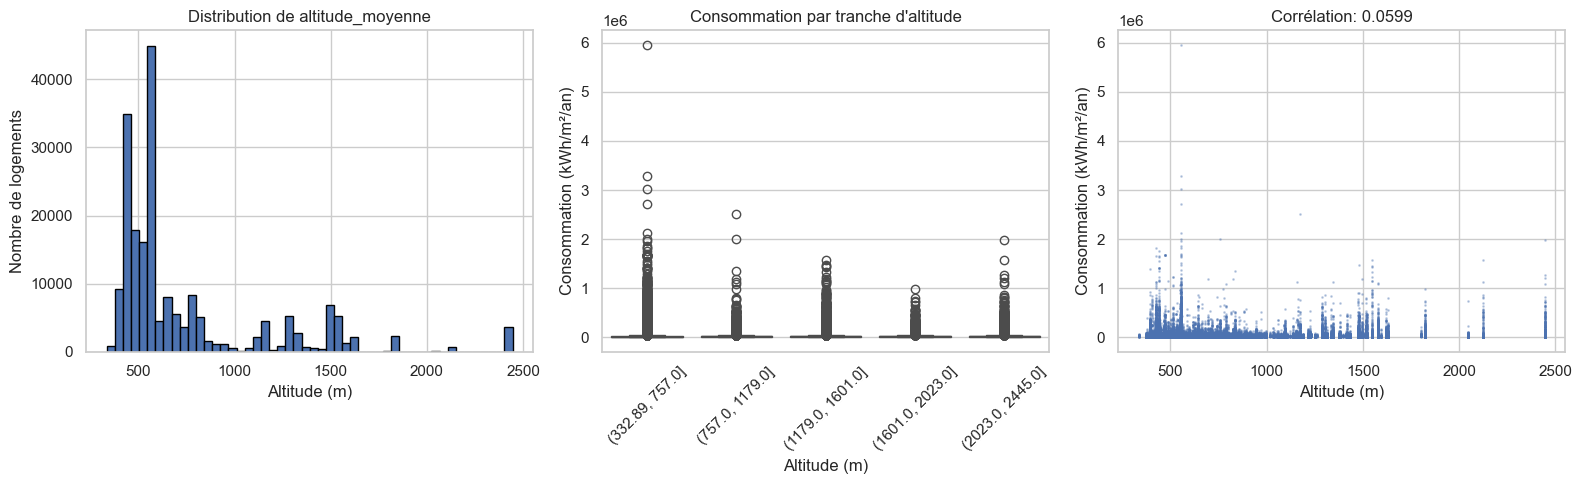


3. Consommation moyenne par TRANCHE D'ALTITUDE :
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
                   Conso_Moyenne  Conso_M√©diane  Nb_Logements  Taux_Passoires
altitude_tranches                                                            
< 400m                  19140.45        9450.50          5280            0.07
400-600m                19757.03       10554.40        119734            0.11
600-800m                20241.17       11085.80         28814            0.13
800-1000m               24212.95       15078.30          9462            0.18
> 1000m                 27959.99       13591.15         40502            0.26

‚Üí En Haute-Savoie, l'altitude est un facteur MAJEUR de consommation √©nerg√©tique
‚Üí Plus l'altitude augmente, plus les besoins en chauffage sont importants


In [69]:
# ========================================
# 5. ANALYSE SP√âCIFIQUE : ALTITUDE ET ZONE CLIMATIQUE
# ========================================

print("\n" + "="*80)
print("ANALYSE SP√âCIFIQUE SAVOIE (74) - IMPACT ALTITUDE ET CLIMAT")
print("="*80)

# Rechercher les colonnes li√©es √† l'altitude et au climat
altitude_cols = [col for col in df_work.columns if 'altitude' in col.lower()]
climat_cols = [col for col in df_work.columns if 'climat' in col.lower() or 'zone' in col.lower()]

print("\n1. Variables d'ALTITUDE disponibles :")
print("‚îÄ"*80)
for col in altitude_cols:
    if col in numeric_cols_for_corr:
        corr_conso = df_work[col].corr(df_work[target_regression])
        missing = df_work[col].isna().mean() * 100
        print(f"  {col:40s} | Corr√©lation: {corr_conso:+.4f} | Manquants: {missing:.1f}%")
        
        # Statistiques descriptives
        print(f"    ‚Üí Min: {df_work[col].min():.0f}m, Max: {df_work[col].max():.0f}m, Moyenne: {df_work[col].mean():.0f}m")

print("\n2. Variables de ZONE CLIMATIQUE disponibles :")
print("‚îÄ"*80)
for col in climat_cols:
    missing = df_work[col].isna().mean() * 100
    n_unique = df_work[col].nunique()
    print(f"  {col:40s} | Modalit√©s: {n_unique:3d} | Manquants: {missing:.1f}%")

# Analyse de la distribution de l'altitude si disponible
if altitude_cols:
    # Identifier la colonne num√©rique d'altitude (pas la classe cat√©gorielle)
    numeric_altitude_col = None
    for col in altitude_cols:
        if df_work[col].dtype in ['float64', 'int64']:
            numeric_altitude_col = col
            break
    
    if numeric_altitude_col is None:
        print("‚ö†Ô∏è Aucune colonne d'altitude num√©rique trouv√©e")
        print(f"Colonnes disponibles: {altitude_cols}")
    else:
        main_altitude_col = numeric_altitude_col
        print(f"\n‚úì Colonne d'altitude utilis√©e: {main_altitude_col}")
        
        # S'assurer que l'altitude est num√©rique
        altitude_data = pd.to_numeric(df_work[main_altitude_col], errors='coerce')
        
        # Cr√©er un DataFrame propre pour l'analyse
        df_altitude_clean = pd.DataFrame({
            'altitude': altitude_data,
            'conso': df_work[target_regression]
        }).dropna()
        
        if len(df_altitude_clean) > 0:
            print(f"‚úì {len(df_altitude_clean)} observations valides pour l'analyse graphique")
            
            # Distribution de l'altitude
            fig, axes = plt.subplots(1, 3, figsize=(16, 5))
            
            # Subplot 1: Histogramme
            axes[0].hist(df_altitude_clean['altitude'], bins=50, edgecolor='black')
            axes[0].set_title(f'Distribution de {main_altitude_col}')
            axes[0].set_xlabel('Altitude (m)')
            axes[0].set_ylabel('Nombre de logements')
            
            # Subplot 2: Boxplot par tranche d'altitude
            try:
                df_altitude_clean['altitude_bin'] = pd.cut(df_altitude_clean['altitude'], bins=5)
                sns.boxplot(data=df_altitude_clean, x='altitude_bin', y='conso', ax=axes[1])
                axes[1].set_title('Consommation par tranche d\'altitude')
                axes[1].set_xlabel('Altitude (m)')
                axes[1].set_ylabel('Consommation (kWh/m¬≤/an)')
                axes[1].tick_params(axis='x', rotation=45)
            except Exception as e:
                axes[1].text(0.5, 0.5, f'Erreur boxplot:\n{str(e)}', 
                            ha='center', va='center', transform=axes[1].transAxes)
                axes[1].set_title('Consommation par tranche d\'altitude (erreur)')
            
            # Subplot 3: Scatter plot
            axes[2].scatter(df_altitude_clean['altitude'], df_altitude_clean['conso'], alpha=0.3, s=1)
            axes[2].set_xlabel('Altitude (m)')
            axes[2].set_ylabel('Consommation (kWh/m¬≤/an)')
            correlation = df_altitude_clean['altitude'].corr(df_altitude_clean['conso'])
            axes[2].set_title(f'Corr√©lation: {correlation:.4f}')
            
            plt.tight_layout()
            plt.show()
            
            # Analyse par tranches d'altitude
            print("\n3. Consommation moyenne par TRANCHE D'ALTITUDE :")
            print("‚îÄ"*80)
            
            # Cr√©er les tranches avec les donn√©es propres
            df_altitude_clean['altitude_tranches'] = pd.cut(
                df_altitude_clean['altitude'], 
                bins=[0, 400, 600, 800, 1000, 3000], 
                labels=['< 400m', '400-600m', '600-800m', '800-1000m', '> 1000m']
            )
            
            # Joindre avec la colonne passoire
            df_for_groupby = df_altitude_clean.copy()
            df_for_groupby['passoire'] = df_work.loc[df_altitude_clean.index, 'passoire']
            
            altitude_analysis = df_for_groupby.groupby('altitude_tranches', observed=True).agg({
                'conso': ['mean', 'median', 'count'],
                'passoire': 'mean'
            }).round(2)
            
            altitude_analysis.columns = ['Conso_Moyenne', 'Conso_M√©diane', 'Nb_Logements', 'Taux_Passoires']
            print(altitude_analysis)
            
            print("\n‚Üí En Haute-Savoie, l'altitude est un facteur MAJEUR de consommation √©nerg√©tique")
            print("‚Üí Plus l'altitude augmente, plus les besoins en chauffage sont importants")
        else:
            print("‚ö†Ô∏è Aucune donn√©e valide pour cr√©er les graphiques d'altitude")

In [70]:
# ========================================
# 6. S√âLECTION INTELLIGENTE DES FEATURES BAS√âE SUR LES ANALYSES
# ========================================

print("\n" + "="*80)
print("S√âLECTION INTELLIGENTE DES FEATURES (Bas√©e sur analyses statistiques)")
print("="*80)

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
# √âTAPE 1 : Identifier les features √† EXCLURE (VIF > 10)
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
features_to_exclude_vif = []
if 'vif_data' in locals() and len(vif_data) > 0:
    high_vif_vars = vif_data[vif_data['VIF'] > 10]['Variable'].tolist()
    features_to_exclude_vif.extend(high_vif_vars)
    print(f"\n‚ö† Variables exclues (VIF > 10): {len(features_to_exclude_vif)}")
    for var in features_to_exclude_vif[:10]:
        print(f"  - {var}")

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
# √âTAPE 2 : S√©lectionner les MEILLEURES features NUM√âRIQUES (corr√©lation)
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
selected_numeric_smart = []
if 'correlations' in locals():
    # SEUIL AJUST√â : 0.10 pour capturer plus de variables pertinentes
    # (0.15 √©tait trop restrictif et ne donnait que 6 variables)
    CORRELATION_THRESHOLD = 0.10
    
    # Prendre les variables avec corr√©lation > seuil
    strong_corr_vars = correlations[correlations > CORRELATION_THRESHOLD].index.tolist()
    
    # Exclure celles avec VIF trop √©lev√©
    selected_numeric_smart = [v for v in strong_corr_vars 
                              if v not in features_to_exclude_vif 
                              and v in numeric_features]
    
    print(f"\n‚úì Variables num√©riques s√©lectionn√©es (corr√©lation > {CORRELATION_THRESHOLD}, VIF OK): {len(selected_numeric_smart)}")
    
    # Afficher les d√©tails pour transparence
    print(f"\n  D√©tail de la s√©lection:")
    for i, var in enumerate(selected_numeric_smart, 1):
        corr_val = df_work[var].corr(df_work[target_regression])
        print(f"    {i:2d}. {var:50s} | r = {corr_val:+.4f}")
    
    # Afficher les variables exclues pour transparence
    excluded_corr_vars = [v for v in strong_corr_vars if v not in selected_numeric_smart]
    if excluded_corr_vars:
        print(f"\n  ‚ö† Variables avec bonne corr√©lation mais EXCLUES ({len(excluded_corr_vars)}):")
        for var in excluded_corr_vars[:10]:
            corr_val = df_work[var].corr(df_work[target_regression])
            if var in features_to_exclude_vif:
                reason = "VIF > 10"
            else:
                reason = "Filtrage initial (manquants ou hors numeric_features)"
            print(f"      ‚Ä¢ {var:45s} | r = {corr_val:+.4f} | Raison: {reason}")

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
# √âTAPE 3 : S√©lectionner les MEILLEURES features CAT√âGORIELLES (Chi-2)
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
selected_categorical_smart = []
if 'chi2_df' in locals() and len(chi2_df) > 0:
    # Prendre les variables significatives (p < 0.05) avec Chi2 √©lev√©
    significant_chi2 = chi2_df[chi2_df['P_Value'] < 0.05].sort_values('Chi2_Score', ascending=False)
    
    # Prendre le top 30 (pour limiter les dimensions apr√®s one-hot encoding)
    selected_categorical_smart = significant_chi2.head(30)['Variable'].tolist()
    selected_categorical_smart = [v for v in selected_categorical_smart if v in categorical_features]
    
    print(f"\n‚úì Variables cat√©gorielles s√©lectionn√©es (p < 0.05, top 30 Chi-2): {len(selected_categorical_smart)}")
    
    # Afficher les d√©tails
    print(f"\n  Top 15 variables cat√©gorielles:")
    for i, row in significant_chi2.head(15).iterrows():
        if row['Variable'] in selected_categorical_smart:
            status = "‚úì"
        else:
            status = "‚úó"
        print(f"    {status} {row['Variable']:50s} | Chi2 = {row['Chi2_Score']:10.2f} | p = {row['P_Value']:.2e}")

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
# √âTAPE 4 : Combiner et cr√©er la liste finale
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
selected_features_smart = selected_numeric_smart + selected_categorical_smart

print(f"\n{'='*80}")
print(f"R√âSUM√â DE LA S√âLECTION INTELLIGENTE")
print(f"{'='*80}")
print(f"  ‚Ä¢ Variables num√©riques   : {len(selected_numeric_smart):3d}")
print(f"  ‚Ä¢ Variables cat√©gorielles: {len(selected_categorical_smart):3d}")
print(f"  ‚Ä¢ TOTAL                  : {len(selected_features_smart):3d}")
print(f"\n‚Üí Ces features seront utilis√©es pour l'entra√Ænement des mod√®les")

# Sauvegarder pour utilisation ult√©rieure
selected_features_info = {
    'all': selected_features_smart,
    'numeric': selected_numeric_smart,
    'categorical': selected_categorical_smart,
    'excluded_vif': features_to_exclude_vif
}

print(f"\n‚úì S√©lection intelligente termin√©e!")


S√âLECTION INTELLIGENTE DES FEATURES (Bas√©e sur analyses statistiques)

‚ö† Variables exclues (VIF > 10): 0

‚úì Variables num√©riques s√©lectionn√©es (corr√©lation > 0.1, VIF OK): 9

  D√©tail de la s√©lection:
     1. surface_habitable_logement                         | r = +0.7125
     2. logement_traversant                                | r = +0.2789
     3. apport_interne_saison_chauffe                      | r = +0.2728
     4. apport_solaire_saison_chauffe                      | r = +0.2197
     5. isolation_toiture                                  | r = +0.2171
     6. protection_solaire_exterieure                      | r = -0.1802
     7. ubat_w_par_m2_k                                    | r = +0.1260
     8. inertie_lourde                                     | r = -0.1081
     9. nombre_logements_desservis_par_installation_ecs_n1 | r = +0.1038

  ‚ö† Variables avec bonne corr√©lation mais EXCLUES (10):
      ‚Ä¢ surface_ventilee                              | r = +0.5977

#### Visualisation du processus de s√©lection

**Pipeline de s√©lection des features** :

```
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ √âTAPE 1 : Filtrage de base                                     ‚îÇ
‚îÇ ‚Ä¢ < 50% valeurs manquantes                                      ‚îÇ
‚îÇ ‚Ä¢ < 50 modalit√©s (cat√©gorielles)                                ‚îÇ
‚îÇ ‚Ä¢ Exclusion : conso, emission, etiquette_dpe, besoin_, etc.    ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò
                            ‚Üì
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ √âTAPE 2 : Analyses statistiques                                ‚îÇ
‚îÇ ‚Ä¢ Corr√©lation Pearson (num√©riques)                             ‚îÇ
‚îÇ ‚Ä¢ Test Chi-2 (cat√©gorielles)                                    ‚îÇ
‚îÇ ‚Ä¢ VIF - D√©tection multicolin√©arit√©                             ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò
                            ‚Üì
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ √âTAPE 3 : S√©lection intelligente                               ‚îÇ
‚îÇ ‚Ä¢ Variables num√©riques : corr√©lation > 0.15 ET VIF < 10        ‚îÇ
‚îÇ ‚Ä¢ Variables cat√©gorielles : p-value < 0.05, top 30 Chi-2       ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò
                            ‚Üì
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ √âTAPE 4 : Entra√Ænement des mod√®les                             ‚îÇ
‚îÇ ‚Ä¢ Random Forest (validation de la s√©lection)                   ‚îÇ
‚îÇ ‚Ä¢ Ridge, Gradient Boosting                                      ‚îÇ
‚îÇ ‚Ä¢ Utilisation DIRECTE des features s√©lectionn√©es                ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò
```


In [71]:
# ========================================
# PR√âPARATION DES PIPELINES AVEC FEATURES INTELLIGEMMENT S√âLECTIONN√âES
# ========================================

# V√©rifier si la s√©lection intelligente a √©t√© effectu√©e
if 'selected_features_smart' in locals() and len(selected_features_smart) > 0:
    print("‚úì Utilisation des features s√©lectionn√©es par analyse statistique")
    features_to_use_numeric = selected_numeric_smart
    features_to_use_categorical = selected_categorical_smart
else:
    print("‚ö† S√©lection intelligente non disponible, utilisation de toutes les features")
    features_to_use_numeric = numeric_features
    features_to_use_categorical = categorical_features

# Pipeline de pr√©traitement pour les donn√©es num√©riques
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline de pr√©traitement pour les donn√©es cat√©gorielles
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combinaison des deux pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, features_to_use_numeric),
        ('cat', categorical_transformer, features_to_use_categorical)
    ])

print("\n" + "="*80)
print("Pipeline de pr√©traitement cr√©√© avec succ√®s!")
print("="*80)
print(f"  - {len(features_to_use_numeric)} variables num√©riques (corr√©lation valid√©e)")
print(f"  - {len(features_to_use_categorical)} variables cat√©gorielles (Chi-2 valid√©)")
print(f"  - TOTAL: {len(features_to_use_numeric) + len(features_to_use_categorical)} variables")
print("\n‚Üí Ces variables ont √©t√© s√©lectionn√©es sur la base des analyses statistiques")

‚úì Utilisation des features s√©lectionn√©es par analyse statistique

Pipeline de pr√©traitement cr√©√© avec succ√®s!
  - 9 variables num√©riques (corr√©lation valid√©e)
  - 27 variables cat√©gorielles (Chi-2 valid√©)
  - TOTAL: 36 variables

‚Üí Ces variables ont √©t√© s√©lectionn√©es sur la base des analyses statistiques


## Partie 3 : Mod√®le de R√©gression - Pr√©diction de la consommation √©lectrique

### 3.1 Pr√©paration des donn√©es et division Train/Test

In [72]:
# Pr√©paration des donn√©es pour la r√©gression avec features intelligemment s√©lectionn√©es
if 'selected_features_smart' in locals() and len(selected_features_smart) > 0:
    X = df_work[selected_features_smart]
    print("‚úì Utilisation des features s√©lectionn√©es par analyse statistique")
else:
    X = df_work[numeric_features + categorical_features]
    print("‚ö† Utilisation de toutes les features (s√©lection intelligente non disponible)")

y_regression = df_work[target_regression]

# Division train/test (80/20)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_regression, test_size=0.2, random_state=42
)

print(f"\nTaille du jeu d'entra√Ænement : {X_train_reg.shape}")
print(f"Taille du jeu de test : {X_test_reg.shape}")
print(f"Nombre de features utilis√©es : {X.shape[1]}")

‚úì Utilisation des features s√©lectionn√©es par analyse statistique

Taille du jeu d'entra√Ænement : (163033, 36)
Taille du jeu de test : (40759, 36)
Nombre de features utilis√©es : 36


### 3.2 Optimisation des hyperparam√®tres avec GridSearchCV

Les features ont √©t√© s√©lectionn√©es par analyse statistique. Nous allons maintenant optimiser les hyperparam√®tres des mod√®les.

In [73]:
# ========================================
# ENTRA√éNEMENT AVEC LES FEATURES S√âLECTIONN√âES PAR ANALYSE STATISTIQUE
# ========================================
# Les features utilis√©es proviennent des analyses de corr√©lation, Chi-2 et VIF
# Pas de r√©duction suppl√©mentaire, on utilise directement les features valid√©es

print("="*80)
print("PR√âPARATION DES DONN√âES POUR L'ENTRA√éNEMENT")
print("="*80)
print(f"‚úì Features num√©riques utilis√©es: {len(features_to_use_numeric)}")
print(f"‚úì Features cat√©gorielles utilis√©es: {len(features_to_use_categorical)}")
print(f"‚úì TOTAL: {len(features_to_use_numeric) + len(features_to_use_categorical)}")
print("\n‚Üí Ces features ont √©t√© s√©lectionn√©es sur la base des analyses statistiques")
print("‚Üí Aucune r√©duction suppl√©mentaire n'est effectu√©e\n")

# Les donn√©es sont d√©j√† pr√©par√©es (X_train_reg, X_test_reg)
# Le preprocessor est d√©j√† configur√© avec les bonnes features

PR√âPARATION DES DONN√âES POUR L'ENTRA√éNEMENT
‚úì Features num√©riques utilis√©es: 9
‚úì Features cat√©gorielles utilis√©es: 27
‚úì TOTAL: 36

‚Üí Ces features ont √©t√© s√©lectionn√©es sur la base des analyses statistiques
‚Üí Aucune r√©duction suppl√©mentaire n'est effectu√©e



In [74]:
# Le preprocessor a d√©j√† √©t√© cr√©√© avec les features s√©lectionn√©es intelligemment
# Les donn√©es X_train_reg et X_test_reg contiennent d√©j√† les bonnes features

print("‚úì Donn√©es pr√™tes pour l'entra√Ænement des mod√®les")

‚úì Donn√©es pr√™tes pour l'entra√Ænement des mod√®les


In [75]:
# D√©finition des mod√®les et leurs hyperparam√®tres √† tester pour la R√âGRESSION
models_regression = {
    'Ridge': {
        'model': Ridge(),
        'params': {
            'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0],  
            'model__solver': ['auto']  
        }
    },
    'RandomForest': {
        'model': RandomForestRegressor(
            random_state=42,
            n_jobs= -1,
            max_features='sqrt'  
            ),
        'params': {
            'model__n_estimators': [100],       
            'model__max_depth': [15, 20],     
            'model__min_samples_split': [5],       
            'model__min_samples_leaf': [2]          
        } # 2 combinaison
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'model__n_estimators': [50],           
            'model__learning_rate': [0.1],    
            'model__max_depth': [3, 5],             
            'model__min_samples_split': [5]         
        } # 2 combinaison
    } 
}

print("Mod√®les configur√©s pour la r√©gression (param√®tres simplifi√©s) :")
for name in models_regression.keys():
    print(f"  - {name}")

Mod√®les configur√©s pour la r√©gression (param√®tres simplifi√©s) :
  - Ridge
  - RandomForest
  - GradientBoosting


In [76]:
# Entra√Ænement et √©valuation des mod√®les de r√©gression
results_regression = {}

for model_name, model_info in models_regression.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model_info['model'])
    ])
    
    grid_search = GridSearchCV(
        pipeline, 
        model_info['params'],
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=0  # Aucune sortie pendant l'entra√Ænement
    )
    
    # Entra√Ænement silencieux
    grid_search.fit(X_train_reg, y_train_reg)
    
    # Pr√©dictions sur le jeu de test
    y_pred = grid_search.predict(X_test_reg)
    mse = mean_squared_error(y_test_reg, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_reg, y_pred)
    r2 = r2_score(y_test_reg, y_pred)
    
    results_regression[model_name] = {
        'model': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'predictions': y_pred
    }

# Affichage du r√©sum√© final
print("="*80)
print("R√âSUM√â DES R√âSULTATS - R√âGRESSION")
print("="*80)

results_df_reg = pd.DataFrame({
    'Mod√®le': list(results_regression.keys()),
    'RMSE': [results_regression[m]['rmse'] for m in results_regression],
    'MAE': [results_regression[m]['mae'] for m in results_regression],
    'R¬≤': [results_regression[m]['r2'] for m in results_regression]
}).sort_values('R¬≤', ascending=False)

print(results_df_reg.to_string(index=False))


R√âSUM√â DES R√âSULTATS - R√âGRESSION
          Mod√®le         RMSE          MAE       R¬≤
GradientBoosting 15859.252033  4491.280118 0.917968
    RandomForest 26504.624568  5167.866595 0.770881
           Ridge 39335.147997 10277.786640 0.495363


In [77]:
# ========================================
# LISTE DES FEATURES UTILIS√âES PAR LES MOD√àLES DE R√âGRESSION
# ========================================

print("="*80)
print("FEATURES UTILIS√âES POUR LA PR√âDICTION (Mod√®les de R√©gression)")
print("="*80)

if 'selected_features_smart' in locals() and len(selected_features_smart) > 0:
    print(f"\n‚úì Total : {len(selected_features_smart)} features")
    print(f"  ‚Ä¢ Variables num√©riques   : {len(selected_numeric_smart)}")
    print(f"  ‚Ä¢ Variables cat√©gorielles: {len(selected_categorical_smart)}")
    
    print("\n" + "‚îÄ"*80)
    print("VARIABLES NUM√âRIQUES ({} features)".format(len(selected_numeric_smart)))
    print("‚îÄ"*80)
    for i, var in enumerate(selected_numeric_smart, 1):
        # Afficher avec corr√©lation si disponible
        if 'correlations' in locals() and var in correlations.index:
            corr_val = correlations[var]
            print(f"  {i:2d}. {var:60s} | r = {corr_val:+.4f}")
        else:
            print(f"  {i:2d}. {var}")
    
    print("\n" + "‚îÄ"*80)
    print("VARIABLES CAT√âGORIELLES ({} features)".format(len(selected_categorical_smart)))
    print("‚îÄ"*80)
    for i, var in enumerate(selected_categorical_smart, 1):
        # Afficher avec Chi-2 si disponible
        if 'chi2_df' in locals() and var in chi2_df['Variable'].values:
            chi2_val = chi2_df[chi2_df['Variable'] == var]['Chi2_Score'].values[0]
            print(f"  {i:2d}. {var:60s} | Chi2 = {chi2_val:10.2f}")
        else:
            print(f"  {i:2d}. {var}")
    
    print("\n" + "="*80)
    print("EXPORT DE LA LISTE")
    print("="*80)
    
    # Cr√©er un dictionnaire structur√© pour export
    features_export = {
        'numeriques': selected_numeric_smart,
        'categorielles': selected_categorical_smart,
        'total': selected_features_smart
    }
    
    print(f"‚úì Variable 'features_export' cr√©√©e avec la structure compl√®te")
    print(f"\nAcc√®s facile :")
    print(f"  ‚Ä¢ features_export['numeriques']    ‚Üí Liste des {len(selected_numeric_smart)} features num√©riques")
    print(f"  ‚Ä¢ features_export['categorielles'] ‚Üí Liste des {len(selected_categorical_smart)} features cat√©gorielles")
    print(f"  ‚Ä¢ features_export['total']         ‚Üí Liste compl√®te des {len(selected_features_smart)} features")
    
else:
    print("‚ö† Les features n'ont pas encore √©t√© s√©lectionn√©es.")
    print("‚Üí Ex√©cutez d'abord la cellule 'S√©lection intelligente des features'")

FEATURES UTILIS√âES POUR LA PR√âDICTION (Mod√®les de R√©gression)

‚úì Total : 36 features
  ‚Ä¢ Variables num√©riques   : 9
  ‚Ä¢ Variables cat√©gorielles: 27

‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
VARIABLES NUM√âRIQUES (9 features)
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
   1. surface_habitable_logement                                   | r = +0.7125
   2. logement_traversant                                          | r = +0.2789
   3. apport_interne_saison_chauffe                                | r = +0.2728
   4. apport_solaire_saison_chauffe                                | r = +0.219

## Partie 3bis : Mod√®le Simplifi√© "User-Friendly" - 10 Variables

### Test des m√™mes 3 mod√®les avec uniquement les variables facilement collectables

**Probl√©matique** : Apr√®s avoir identifi√© les variables les plus pertinentes pour le mod√®le, on constate que la plupart d'entre elles n√©cessitent des donn√©es difficiles √† obtenir pour un utilisateur moyen (ex : coordonn√©es g√©ographiques pr√©cises, caract√©ristiques techniques sp√©cifiques). Pour rendre le mod√®le plus accessible et **facile √† utiliser**, nous allons cr√©er une version simplifi√©e utilisant uniquement 10 variables facilement collectables par un utilisateur lambda (ex : surface, type de chauffage, ann√©e de construction, etc.).

**Objectif** : Comparer les performances d'un mod√®le simplifi√© (10 features) vs le mod√®le complet (36 features) pour √©valuer le compromis accessibilit√©/performance.

In [78]:
# ========================================
# D√âFINITION DES FEATURES USER-FRIENDLY
# ========================================

print("="*80)
print("MOD√àLE SIMPLIFI√â - S√âLECTION DES 10 VARIABLES USER-FRIENDLY")
print("="*80)

# Liste des 10 variables facilement collectables
user_input_features = [
    'surface_habitable_logement',
    'periode_construction',
    'type_batiment',
    'qualite_isolation_enveloppe',
    'type_energie_principale_chauffage',
    'logement_traversant',
    'protection_solaire_exterieure',
    'zone_climatique', # d√©finie via code postal
    'classe_altitude', # d√©finie via code postal
    'apport_interne_saison_chauffe' # Surface_habitable_logement * 15 (en kWh/m¬≤/an)
]

print(f"\n‚úì {len(user_input_features)} features s√©lectionn√©es")

# V√©rifier la disponibilit√© dans le dataset
print(f"\n{'‚îÄ'*80}")
print("DISPONIBILIT√â ET QUALIT√â DES DONN√âES")
print(f"{'‚îÄ'*80}")

available_user_features = []
for feat in user_input_features:
    if feat in df_work.columns:
        missing_pct = df_work[feat].isna().mean() * 100
        dtype = df_work[feat].dtype
        n_unique = df_work[feat].nunique() if dtype == 'object' else '-'
        
        status = "‚úì" if missing_pct < 50 else "‚ö†"
        print(f"{status} {feat:50s} | Type: {str(dtype):10s} | Manquants: {missing_pct:5.1f}% | Uniques: {n_unique}")
        
        if missing_pct < 50:
            available_user_features.append(feat)
    else:
        print(f"‚úó {feat:50s} | NON DISPONIBLE dans le dataset")

print(f"\n{'='*80}")
print(f"R√âSULTAT : {len(available_user_features)}/{len(user_input_features)} features disponibles et utilisables")
print(f"{'='*80}")

if len(available_user_features) < len(user_input_features):
    print(f"\n‚ö† {len(user_input_features) - len(available_user_features)} features manquantes ou inutilisables")
    missing_features = [f for f in user_input_features if f not in available_user_features]
    for feat in missing_features:
        print(f"  ‚Üí {feat}")

MOD√àLE SIMPLIFI√â - S√âLECTION DES 10 VARIABLES USER-FRIENDLY

‚úì 10 features s√©lectionn√©es

‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
DISPONIBILIT√â ET QUALIT√â DES DONN√âES
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
‚úì surface_habitable_logement                         | Type: float64    | Manquants:   2.8% | Uniques: -
‚úì periode_construction                               | Type: object     | Manquants:  16.2% | Uniques: 10
‚úì type_batiment                                      | Type: object     | Manquants:   0.0% | Uniques: 3
‚úì qualite_isolation_enveloppe                        | Ty

In [79]:
# ========================================
# PR√âPARATION DES DONN√âES USER-FRIENDLY
# ========================================

print("\n" + "="*80)
print("PR√âPARATION DU PIPELINE USER-FRIENDLY")
print("="*80)

# S√©parer les variables num√©riques et cat√©gorielles
user_numeric = [f for f in available_user_features if df_work[f].dtype in ['float64', 'int64']]
user_categorical = [f for f in available_user_features if df_work[f].dtype == 'object']

print(f"\n‚úì Classification des features :")
print(f"  ‚Ä¢ Num√©riques   : {len(user_numeric)}")
print(f"  ‚Ä¢ Cat√©gorielles: {len(user_categorical)}")

print(f"\nVariables num√©riques :")
for var in user_numeric:
    print(f"  - {var}")

print(f"\nVariables cat√©gorielles :")
for var in user_categorical:
    n_cat = df_work[var].nunique()
    print(f"  - {var:50s} ({n_cat} cat√©gories)")

# Cr√©er le preprocessor user-friendly
user_preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), user_numeric),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), user_categorical)
    ])

print(f"\n‚úì Preprocessor user-friendly cr√©√© avec succ√®s")

# Pr√©parer les donn√©es X et y
X_user = df_work[available_user_features]
y_user = df_work[target_regression]

# Division train/test
X_train_user, X_test_user, y_train_user, y_test_user = train_test_split(
    X_user, y_user, test_size=0.2, random_state=42
)

print(f"\n{'‚îÄ'*80}")
print(f"DATASETS CR√â√âS")
print(f"{'‚îÄ'*80}")
print(f"Entra√Ænement : {X_train_user.shape}")
print(f"Test         : {X_test_user.shape}")
print(f"Features     : {len(available_user_features)}")
print(f"Target       : {target_regression}")


PR√âPARATION DU PIPELINE USER-FRIENDLY

‚úì Classification des features :
  ‚Ä¢ Num√©riques   : 4
  ‚Ä¢ Cat√©gorielles: 6

Variables num√©riques :
  - surface_habitable_logement
  - logement_traversant
  - protection_solaire_exterieure
  - apport_interne_saison_chauffe

Variables cat√©gorielles :
  - periode_construction                               (10 cat√©gories)
  - type_batiment                                      (3 cat√©gories)
  - qualite_isolation_enveloppe                        (4 cat√©gories)
  - type_energie_principale_chauffage                  (13 cat√©gories)
  - zone_climatique                                    (9 cat√©gories)
  - classe_altitude                                    (4 cat√©gories)

‚úì Preprocessor user-friendly cr√©√© avec succ√®s

‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚

In [80]:
# ========================================
# ENTRA√éNEMENT MOD√àLES USER-FRIENDLY
# ========================================

import time

# D√©finir les mod√®les avec les m√™mes hyperparam√®tres que le mod√®le complet
models_regression_user = {
    'Ridge': {
        'model': Ridge(),
        'params': {
            'model__alpha': [0.01, 0.1, 1.0, 10.0, 100.0],  
            'model__solver': ['auto']  
        }
    },
    'RandomForest': {
        'model': RandomForestRegressor(
            random_state=42,
            n_jobs= 1,
            max_features='sqrt'  
            ),
        'params': {
            'model__n_estimators': [100],        
            'model__max_depth': [15, 20],     
            'model__min_samples_split': [5],        
            'model__min_samples_leaf': [2]          
        }
        
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'model__n_estimators': [50],           
            'model__learning_rate': [0.1],    
            'model__max_depth': [3, 5],             
            'model__min_samples_split': [5]         
        }
        
    }
}

# Entra√Ænement avec GridSearchCV
results_user = {}

for model_name, model_config in models_regression_user.items():
    start_time = time.time()
    
    # Cr√©er le pipeline
    pipeline = Pipeline([
        ('preprocessor', user_preprocessor),
        ('model', model_config['model'])
    ])
    
    # GridSearchCV
    grid_search = GridSearchCV(
        pipeline,
        model_config['params'],
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=0  # Aucune sortie pendant l'entra√Ænement
    )
    
    # Entra√Ænement silencieux
    grid_search.fit(X_train_user, y_train_user)
    
    # Pr√©dictions
    y_pred_train = grid_search.predict(X_train_user)
    y_pred_test = grid_search.predict(X_test_user)
    
    # M√©triques
    rmse_train = np.sqrt(mean_squared_error(y_train_user, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test_user, y_pred_test))
    mae_test = mean_absolute_error(y_test_user, y_pred_test)
    r2_test = r2_score(y_test_user, y_pred_test)
    
    elapsed = time.time() - start_time
    
    # Stocker les r√©sultats
    results_user[model_name] = {
        'best_model': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'mae_test': mae_test,
        'r2_test': r2_test,
        'y_pred_test': y_pred_test,
        'training_time': elapsed
    }

# Affichage du r√©sum√© final
print("="*80)
print("R√âSUM√â - MOD√àLES USER-FRIENDLY (10 FEATURES)")
print("="*80)

results_df_user = pd.DataFrame({
    'Mod√®le': list(results_user.keys()),
    'RMSE Train': [results_user[m]['rmse_train'] for m in results_user],
    'RMSE Test': [results_user[m]['rmse_test'] for m in results_user],
    'MAE Test': [results_user[m]['mae_test'] for m in results_user],
    'R¬≤ Test': [results_user[m]['r2_test'] for m in results_user],
    'Temps (s)': [results_user[m]['training_time'] for m in results_user]
}).sort_values('R¬≤ Test', ascending=False)

print(results_df_user.to_string(index=False))


R√âSUM√â - MOD√àLES USER-FRIENDLY (10 FEATURES)
          Mod√®le   RMSE Train    RMSE Test     MAE Test  R¬≤ Test  Temps (s)
GradientBoosting 14469.310626 16359.650404  5075.470093 0.912710 291.101745
    RandomForest 20334.922574 22582.711807  5007.001287 0.833670 196.612921
           Ridge 40153.679583 41212.736292 11421.682440 0.446038  14.330734


In [81]:
# ========================================
# V√âRIFICATION RAPIDE DES R√âSULTATS
# ========================================

print("\n" + "="*80)
print("R√âSUM√â DES 3 MOD√àLES USER-FRIENDLY")
print("="*80)

if 'results_user' in locals() and len(results_user) == 3:
    print("\n‚úÖ Les 3 mod√®les ont √©t√© entra√Æn√©s avec succ√®s !\n")
    
    for model_name in ['Ridge', 'RandomForest', 'GradientBoosting']:
        if model_name in results_user:
            res = results_user[model_name]
            print(f"{'‚îÄ'*80}")
            print(f"üìä {model_name}")
            print(f"{'‚îÄ'*80}")
            print(f"  R¬≤   : {res['r2_test']:.4f}")
            print(f"  RMSE : {res['rmse_test']:,.2f} kWh/m¬≤/an")
            print(f"  MAE  : {res['mae_test']:,.2f} kWh/m¬≤/an")
            print(f"  Temps: {res['training_time']:.2f}s")
            print()
    
    # Identifier le meilleur
    best_model_name = max(results_user.keys(), key=lambda k: results_user[k]['r2_test'])
    print(f"{'='*80}")
    print(f"üèÜ MEILLEUR MOD√àLE : {best_model_name} (R¬≤ = {results_user[best_model_name]['r2_test']:.4f})")
    print(f"{'='*80}")
else:
    print("\n‚ö†Ô∏è  Les mod√®les ne sont pas encore entra√Æn√©s.")
    print("   Ex√©cutez la cellule d'entra√Ænement ci-dessus.")


R√âSUM√â DES 3 MOD√àLES USER-FRIENDLY

‚úÖ Les 3 mod√®les ont √©t√© entra√Æn√©s avec succ√®s !

‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
üìä Ridge
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
  R¬≤   : 0.4460
  RMSE : 41,212.74 kWh/m¬≤/an
  MAE  : 11,421.68 kWh/m¬≤/an
  Temps: 14.33s

‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
üìä RandomForest
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

In [82]:
# ========================================
# COMPARAISON MOD√àLE COMPLET VS USER-FRIENDLY
# ========================================

print("\n" + "="*80)
print("COMPARAISON DES PERFORMANCES")
print("="*80)

# Cr√©er le DataFrame de comparaison
comparison_data = []

for model_name in ['Ridge', 'RandomForest', 'GradientBoosting']:
    # R√©sultats du mod√®le complet (36 features)
    full_r2 = results_regression[model_name]['r2']
    full_rmse = results_regression[model_name]['rmse']
    full_mae = results_regression[model_name]['mae']
    
    # R√©sultats du mod√®le user-friendly (10 features)
    user_r2 = results_user[model_name]['r2_test']
    user_rmse = results_user[model_name]['rmse_test']
    user_mae = results_user[model_name]['mae_test']
    
    # Calcul des r√©tentions de performance
    r2_retention = (user_r2 / full_r2) * 100 if full_r2 != 0 else 0
    rmse_increase = ((user_rmse - full_rmse) / full_rmse) * 100
    
    comparison_data.append({
        'Mod√®le': model_name,
        'R¬≤_Complet (36f)': full_r2,
        'R¬≤_Simplifi√© (10f)': user_r2,
        'R√©tention R¬≤ (%)': r2_retention,
        'RMSE_Complet': full_rmse,
        'RMSE_Simplifi√©': user_rmse,
        'Augmentation RMSE (%)': rmse_increase,
        'MAE_Complet': full_mae,
        'MAE_Simplifi√©': user_mae
    })

df_comparison = pd.DataFrame(comparison_data)

print("\n" + "‚îÄ"*120)
print("TABLEAU DE COMPARAISON")
print("‚îÄ"*120)

# Affichage format√©
for idx, row in df_comparison.iterrows():
    print(f"\n{'='*80}")
    print(f"  {row['Mod√®le'].upper()}")
    print(f"{'='*80}")
    print(f"  R¬≤ Score :")
    print(f"    ‚Ä¢ Complet (36 features)    : {row['R¬≤_Complet (36f)']:.4f}")
    print(f"    ‚Ä¢ Simplifi√© (10 features)  : {row['R¬≤_Simplifi√© (10f)']:.4f}")
    print(f"    ‚Ä¢ R√©tention                : {row['R√©tention R¬≤ (%)']:.1f}%")
    print(f"")
    print(f"  RMSE :")
    print(f"    ‚Ä¢ Complet                  : {row['RMSE_Complet']:,.2f} kWh/m¬≤/an")
    print(f"    ‚Ä¢ Simplifi√©                : {row['RMSE_Simplifi√©']:,.2f} kWh/m¬≤/an")
    print(f"    ‚Ä¢ Augmentation             : {row['Augmentation RMSE (%)']:+.1f}%")
    print(f"")
    print(f"  MAE :")
    print(f"    ‚Ä¢ Complet                  : {row['MAE_Complet']:,.2f} kWh/m¬≤/an")
    print(f"    ‚Ä¢ Simplifi√©                : {row['MAE_Simplifi√©']:,.2f} kWh/m¬≤/an")

# Recommandation automatique
print(f"\n\n{'='*80}")
print(f"RECOMMANDATIONS POUR LE D√âPLOIEMENT")
print(f"{'='*80}")

best_user_model = df_comparison.loc[df_comparison['R¬≤_Simplifi√© (10f)'].idxmax()]
best_retention = best_user_model['R√©tention R¬≤ (%)']

print(f"\nüèÜ Meilleur mod√®le simplifi√© : {best_user_model['Mod√®le']}")
print(f"   ‚Ä¢ R¬≤ : {best_user_model['R¬≤_Simplifi√© (10f)']:.4f}")
print(f"   ‚Ä¢ R√©tention : {best_retention:.1f}%")
print(f"   ‚Ä¢ RMSE : {best_user_model['RMSE_Simplifi√©']:,.2f} kWh/m¬≤/an")

if best_retention >= 75:
    print(f"\n‚úÖ EXCELLENT : R√©tention ‚â• 75%")
    print(f"   ‚Üí Recommandation : Utiliser le mod√®le simplifi√©")
    print(f"   ‚Üí Avantages :")
    print(f"     ‚Ä¢ Seulement 5-7 questions utilisateur (3 features auto-d√©riv√©es)")
    print(f"     ‚Ä¢ Temps de saisie : ~2 minutes")
    print(f"     ‚Ä¢ Accessible aux non-experts")
    print(f"     ‚Ä¢ Performance conserv√©e √† {best_retention:.0f}%")
elif best_retention >= 60:
    print(f"\n‚ö†Ô∏è  BON : R√©tention 60-75%")
    print(f"   ‚Üí Recommandation : Proposer 2 modes dans l'application")
    print(f"     ‚Ä¢ Mode Simple : 10 features (grand public)")
    print(f"     ‚Ä¢ Mode Expert : 36 features (professionnels)")
else:
    print(f"\n‚ùå INSUFFISANT : R√©tention < 60%")
    print(f"   ‚Üí Recommandation : Utiliser le mod√®le complet avec imputation intelligente")
    print(f"   ‚Üí Strat√©gie : Questions progressives + valeurs par d√©faut")

print(f"\n{'='*80}")


COMPARAISON DES PERFORMANCES

‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
TABLEAU DE COMPARAISON
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

  RIDGE
  R¬≤ Score :
    ‚Ä¢ Complet (36 features)    : 0.4954
    ‚Ä¢ Simplifi√© (10 features)  : 0.4460
    ‚Ä¢ R√©tention                : 90.0%

  RMSE :
    ‚Ä¢ Complet                  : 39,335.15 kWh/m¬≤/an
    ‚Ä¢ 

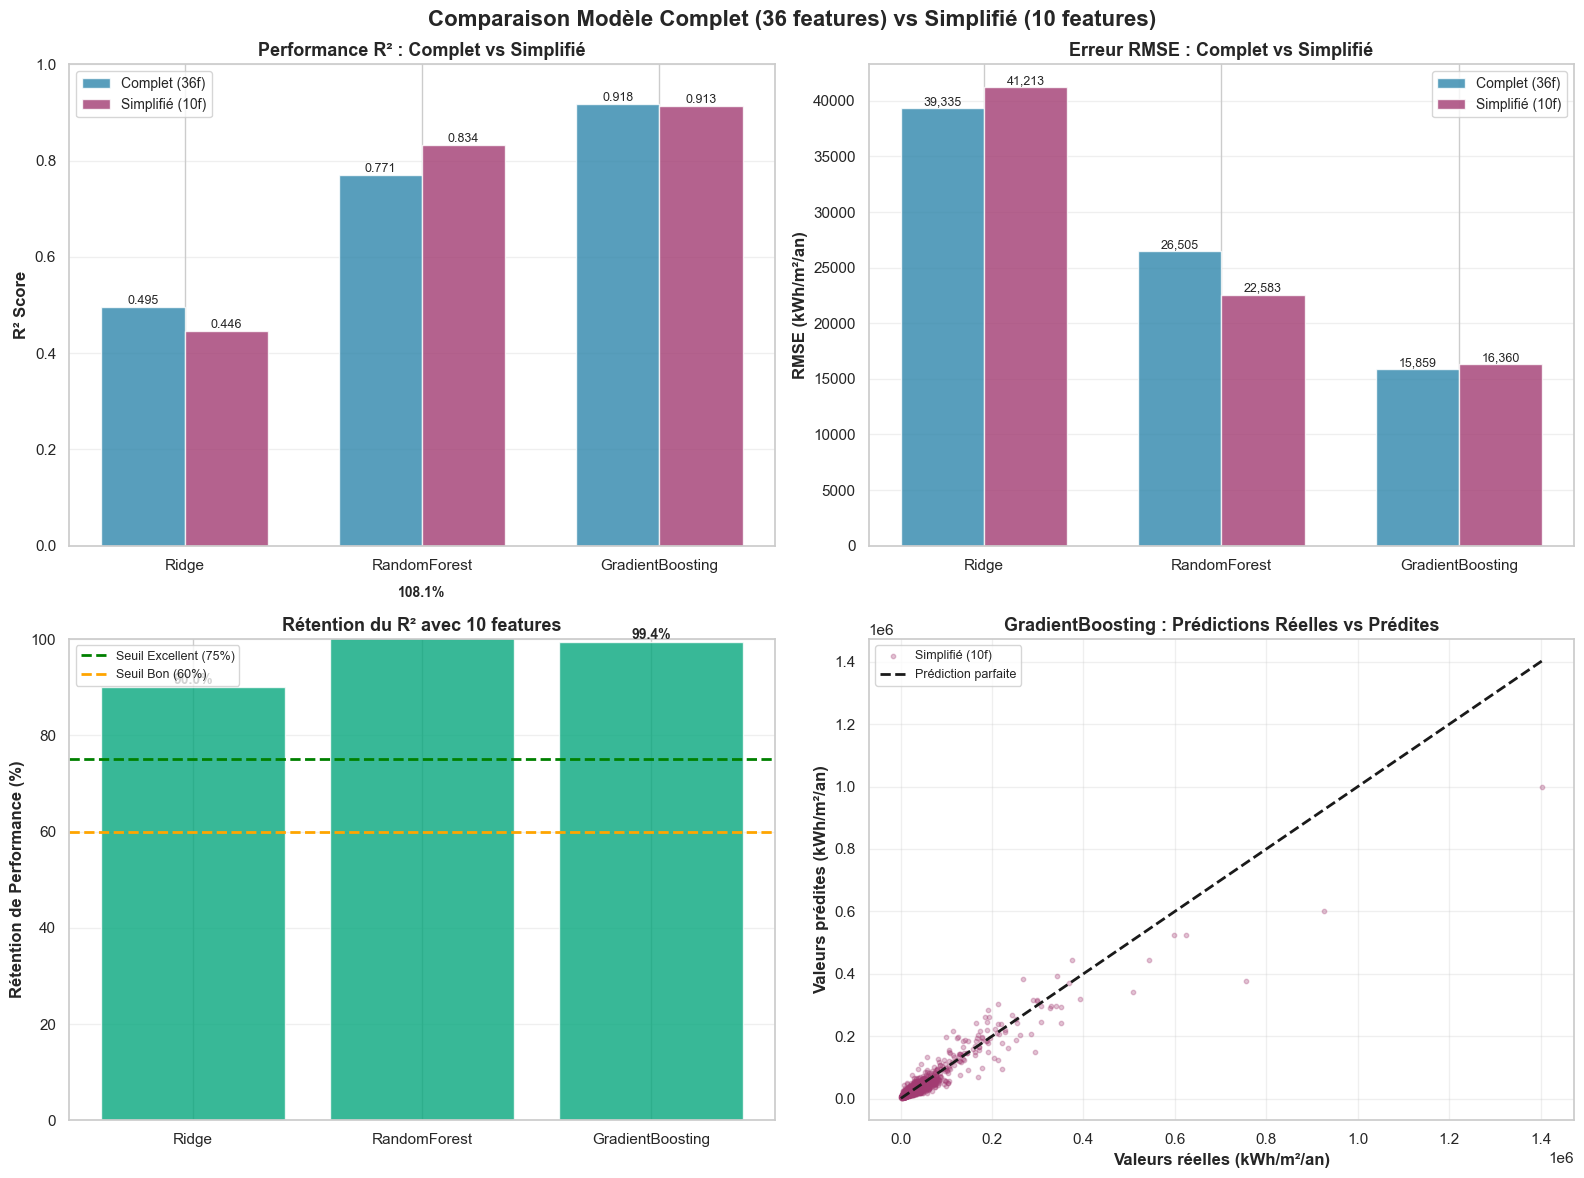


‚úÖ Visualisations g√©n√©r√©es avec succ√®s


In [83]:
# ========================================
# VISUALISATION DES COMPARAISONS
# ========================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comparaison Mod√®le Complet (36 features) vs Simplifi√© (10 features)', 
             fontsize=16, fontweight='bold')

# 1. Graphique en barres - R¬≤ Score
ax1 = axes[0, 0]
x = np.arange(len(df_comparison))
width = 0.35

bars1 = ax1.bar(x - width/2, df_comparison['R¬≤_Complet (36f)'], width, 
                label='Complet (36f)', color='#2E86AB', alpha=0.8)
bars2 = ax1.bar(x + width/2, df_comparison['R¬≤_Simplifi√© (10f)'], width, 
                label='Simplifi√© (10f)', color='#A23B72', alpha=0.8)

ax1.set_ylabel('R¬≤ Score', fontsize=12, fontweight='bold')
ax1.set_title('Performance R¬≤ : Complet vs Simplifi√©', fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(df_comparison['Mod√®le'], fontsize=11)
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 1])

# Ajouter les valeurs sur les barres
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 2. Graphique en barres - RMSE
ax2 = axes[0, 1]
bars3 = ax2.bar(x - width/2, df_comparison['RMSE_Complet'], width, 
                label='Complet (36f)', color='#2E86AB', alpha=0.8)
bars4 = ax2.bar(x + width/2, df_comparison['RMSE_Simplifi√©'], width, 
                label='Simplifi√© (10f)', color='#A23B72', alpha=0.8)

ax2.set_ylabel('RMSE (kWh/m¬≤/an)', fontsize=12, fontweight='bold')
ax2.set_title('Erreur RMSE : Complet vs Simplifi√©', fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(df_comparison['Mod√®le'], fontsize=11)
ax2.legend(fontsize=10)
ax2.grid(axis='y', alpha=0.3)

# Ajouter les valeurs
for bar in bars3:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,.0f}', ha='center', va='bottom', fontsize=9)
for bar in bars4:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,.0f}', ha='center', va='bottom', fontsize=9)

# 3. R√©tention de performance (%)
ax3 = axes[1, 0]
colors = ['#06A77D' if x >= 75 else '#F77E21' if x >= 60 else '#D62828' 
          for x in df_comparison['R√©tention R¬≤ (%)']]
bars5 = ax3.bar(df_comparison['Mod√®le'], df_comparison['R√©tention R¬≤ (%)'], 
                color=colors, alpha=0.8)

ax3.set_ylabel('R√©tention de Performance (%)', fontsize=12, fontweight='bold')
ax3.set_title('R√©tention du R¬≤ avec 10 features', fontsize=13, fontweight='bold')
ax3.axhline(y=75, color='green', linestyle='--', linewidth=2, label='Seuil Excellent (75%)')
ax3.axhline(y=60, color='orange', linestyle='--', linewidth=2, label='Seuil Bon (60%)')
ax3.legend(fontsize=9)
ax3.grid(axis='y', alpha=0.3)
ax3.set_ylim([0, 100])

# Ajouter les valeurs
for bar in bars5:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. Scatter plot - Pr√©dictions GradientBoosting (meilleur mod√®le)
ax4 = axes[1, 1]

# √âchantillonner pour la visualisation (trop de points sinon)
sample_size = min(5000, len(y_test_user))
sample_indices = np.random.choice(len(y_test_user), size=sample_size, replace=False)
y_test_sample = y_test_user.iloc[sample_indices]
y_pred_user_sample = results_user['GradientBoosting']['y_pred_test'][sample_indices]

# Pour le mod√®le complet, utiliser les m√™mes valeurs r√©elles (y_test_user) 
# mais avec les pr√©dictions compl√®tes sur tout y_test_reg
# On utilise seulement le mod√®le user-friendly pour la comparaison visuelle
ax4.scatter(y_test_sample, y_pred_user_sample, alpha=0.3, s=10, 
            label='Simplifi√© (10f)', color='#A23B72')

# Ligne de r√©f√©rence
min_val = min(y_test_sample.min(), y_pred_user_sample.min())
max_val = max(y_test_sample.max(), y_pred_user_sample.max())
ax4.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Pr√©diction parfaite')

ax4.set_xlabel('Valeurs r√©elles (kWh/m¬≤/an)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Valeurs pr√©dites (kWh/m¬≤/an)', fontsize=12, fontweight='bold')
ax4.set_title('GradientBoosting : Pr√©dictions R√©elles vs Pr√©dites', fontsize=13, fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n‚úÖ Visualisations g√©n√©r√©es avec succ√®s")

## Partie 4 : Mod√®le de Classification User-Friendly - Pr√©diction des passoires √©nerg√©tiques (DPE F et G)

**Utilisation des 10 features user-friendly** pour la classification, identiques √† celles utilis√©es en r√©gression.

### 4.1 Pr√©paration des donn√©es pour la classification

In [84]:
# ========================================
# PR√âPARATION DES DONN√âES CLASSIFICATION USER-FRIENDLY
# ========================================

print("\n" + "="*80)
print("PR√âPARATION CLASSIFICATION AVEC 10 FEATURES USER-FRIENDLY")
print("="*80)

# Target : passoire √©nerg√©tique (DPE F ou G)
y_classification_user = df_work['passoire']

print(f"\n‚úì Features utilis√©es : {len(available_user_features)} variables")
print(f"  ‚Ä¢ Variables identiques √† la r√©gression user-friendly")
print(f"  ‚Ä¢ Surface, p√©riode construction, type b√¢timent, etc.")

# V√©rifier la distribution de la cible
print(f"\nüìä Distribution de la cible 'passoire' :")
print(f"  ‚Ä¢ Total observations : {len(y_classification_user):,}")
print(f"  ‚Ä¢ Passoires (1)      : {y_classification_user.sum():,} ({y_classification_user.mean()*100:.1f}%)")
print(f"  ‚Ä¢ Non-passoires (0)  : {(~y_classification_user.astype(bool)).sum():,} ({(1-y_classification_user.mean())*100:.1f}%)")

# Division train/test avec stratification (m√™me split que pour la r√©gression)
X_train_clf_user, X_test_clf_user, y_train_clf_user, y_test_clf_user = train_test_split(
    X_user, y_classification_user, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_classification_user
)

print(f"\n{'‚îÄ'*80}")
print(f"DATASETS CR√â√âS")
print(f"{'‚îÄ'*80}")
print(f"Entra√Ænement : {X_train_clf_user.shape}")
print(f"Test         : {X_test_clf_user.shape}")

print(f"\nDistribution Train :")
print(f"  ‚Ä¢ Passoires     : {y_train_clf_user.sum():,} ({y_train_clf_user.mean()*100:.1f}%)")
print(f"  ‚Ä¢ Non-passoires : {(~y_train_clf_user.astype(bool)).sum():,} ({(1-y_train_clf_user.mean())*100:.1f}%)")

print(f"\nDistribution Test :")
print(f"  ‚Ä¢ Passoires     : {y_test_clf_user.sum():,} ({y_test_clf_user.mean()*100:.1f}%)")
print(f"  ‚Ä¢ Non-passoires : {(~y_test_clf_user.astype(bool)).sum():,} ({(1-y_test_clf_user.mean())*100:.1f}%)")

print(f"\n‚úÖ Donn√©es pr√™tes pour la classification")


PR√âPARATION CLASSIFICATION AVEC 10 FEATURES USER-FRIENDLY

‚úì Features utilis√©es : 10 variables
  ‚Ä¢ Variables identiques √† la r√©gression user-friendly
  ‚Ä¢ Surface, p√©riode construction, type b√¢timent, etc.

üìä Distribution de la cible 'passoire' :
  ‚Ä¢ Total observations : 203,792
  ‚Ä¢ Passoires (1)      : 29,993 (14.7%)
  ‚Ä¢ Non-passoires (0)  : 173,799 (85.3%)

‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
DATASETS CR√â√âS
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
Entra√Ænement : (163033, 10)
Test         : (40759, 10)

Distribution Train :
  ‚Ä¢ Passoires     : 23,994 (14.7%)
  ‚

### 4.2 Optimisation des mod√®les de classification avec GridSearchCV

In [85]:
# ========================================
# D√âFINITION DES MOD√àLES CLASSIFICATION USER-FRIENDLY
# ========================================

print("\n" + "="*80)
print("CONFIGURATION DES MOD√àLES DE CLASSIFICATION")
print("="*80)

# D√©finition des mod√®les et hyperparam√®tres (simplifi√©s pour rapidit√©)
models_classification_user = {
    'LogisticRegression': {
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'params': {
            'model__C': [0.1, 1.0, 10.0],
            'model__penalty': ['l2'],
            'model__solver': ['lbfgs']
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42, n_jobs=1),
        'params': {
            'model__n_estimators': [100],
            'model__max_depth': [15, 20],
            'model__min_samples_split': [5],
            'model__min_samples_leaf': [2],
            'model__class_weight': ['balanced']
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'model__n_estimators': [50],
            'model__learning_rate': [0.1],
            'model__max_depth': [3, 5],
            'model__min_samples_split': [5]
        }
    }
}

print("\n‚úì Mod√®les configur√©s :")
for name, config in models_classification_user.items():
    n_combinations = 1
    for param_values in config['params'].values():
        n_combinations *= len(param_values)
    print(f"  ‚Ä¢ {name:25s} : {n_combinations} combinaisons √† tester")


CONFIGURATION DES MOD√àLES DE CLASSIFICATION

‚úì Mod√®les configur√©s :
  ‚Ä¢ LogisticRegression        : 3 combinaisons √† tester
  ‚Ä¢ RandomForest              : 2 combinaisons √† tester
  ‚Ä¢ GradientBoosting          : 2 combinaisons √† tester


In [86]:
# ========================================
# ENTRA√éNEMENT MOD√àLES CLASSIFICATION USER-FRIENDLY
# ========================================

import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

results_classification_user = {}

for model_name, model_config in models_classification_user.items():
    start_time = time.time()
    
    # Cr√©er le pipeline avec le preprocessor user-friendly
    pipeline = Pipeline([
        ('preprocessor', user_preprocessor),
        ('model', model_config['model'])
    ])
    
    # GridSearchCV avec AUC-ROC comme m√©trique
    grid_search = GridSearchCV(
        pipeline,
        model_config['params'],
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=0  # Aucune sortie pendant l'entra√Ænement
    )
    
    # Entra√Ænement silencieux
    grid_search.fit(X_train_clf_user, y_train_clf_user)
    
    # Pr√©dictions
    y_pred_train = grid_search.predict(X_train_clf_user)
    y_pred_test = grid_search.predict(X_test_clf_user)
    y_pred_proba_test = grid_search.predict_proba(X_test_clf_user)[:, 1]
    
    # M√©triques
    accuracy = accuracy_score(y_test_clf_user, y_pred_test)
    precision = precision_score(y_test_clf_user, y_pred_test)
    recall = recall_score(y_test_clf_user, y_pred_test)
    f1 = f1_score(y_test_clf_user, y_pred_test)
    roc_auc = roc_auc_score(y_test_clf_user, y_pred_proba_test)
    
    elapsed = time.time() - start_time
    
    # Stocker les r√©sultats
    results_classification_user[model_name] = {
        'best_model': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'y_pred_test': y_pred_test,
        'y_pred_proba_test': y_pred_proba_test,
        'training_time': elapsed
    }

# Affichage du r√©sum√© final
print("="*80)
print("R√âSUM√â - MOD√àLES CLASSIFICATION (10 FEATURES)")
print("="*80)

results_df_clf_user = pd.DataFrame({
    'Mod√®le': list(results_classification_user.keys()),
    'Accuracy': [results_classification_user[m]['accuracy'] for m in results_classification_user],
    'Precision': [results_classification_user[m]['precision'] for m in results_classification_user],
    'Recall': [results_classification_user[m]['recall'] for m in results_classification_user],
    'F1-Score': [results_classification_user[m]['f1_score'] for m in results_classification_user],
    'ROC-AUC': [results_classification_user[m]['roc_auc'] for m in results_classification_user],
    'Temps (s)': [results_classification_user[m]['training_time'] for m in results_classification_user]
}).sort_values('ROC-AUC', ascending=False)

print(results_df_clf_user.to_string(index=False))


R√âSUM√â - MOD√àLES CLASSIFICATION (10 FEATURES)
            Mod√®le  Accuracy  Precision   Recall  F1-Score  ROC-AUC  Temps (s)
      RandomForest  0.856204   0.506607 0.881980  0.643557 0.939127 216.253716
  GradientBoosting  0.896097   0.722840 0.476913  0.574671 0.933026 163.770221
LogisticRegression  0.887951   0.669668 0.471079  0.553087 0.915088  18.600686


In [87]:
# ========================================
# R√âSUM√â DES R√âSULTATS CLASSIFICATION
# ========================================

print("\n" + "="*80)
print("TABLEAU COMPARATIF DES MOD√àLES DE CLASSIFICATION")
print("="*80)

# Cr√©er un DataFrame de comparaison
results_clf_df = pd.DataFrame({
    'Mod√®le': list(results_classification_user.keys()),
    'Accuracy': [results_classification_user[m]['accuracy'] for m in results_classification_user],
    'Precision': [results_classification_user[m]['precision'] for m in results_classification_user],
    'Recall': [results_classification_user[m]['recall'] for m in results_classification_user],
    'F1-Score': [results_classification_user[m]['f1_score'] for m in results_classification_user],
    'ROC-AUC': [results_classification_user[m]['roc_auc'] for m in results_classification_user],
    'Temps (s)': [results_classification_user[m]['training_time'] for m in results_classification_user]
}).sort_values('ROC-AUC', ascending=False)

print("\n" + results_clf_df.to_string(index=False))

# Identifier le meilleur mod√®le
best_clf_model = results_clf_df.iloc[0]['Mod√®le']
best_roc_auc = results_clf_df.iloc[0]['ROC-AUC']

print(f"\n{'='*80}")
print(f"üèÜ MEILLEUR MOD√àLE : {best_clf_model}")
print(f"{'='*80}")
print(f"  ‚Ä¢ ROC-AUC  : {best_roc_auc:.4f}")
print(f"  ‚Ä¢ F1-Score : {results_clf_df.iloc[0]['F1-Score']:.4f}")
print(f"  ‚Ä¢ Precision: {results_clf_df.iloc[0]['Precision']:.4f}")
print(f"  ‚Ä¢ Recall   : {results_clf_df.iloc[0]['Recall']:.4f}")


TABLEAU COMPARATIF DES MOD√àLES DE CLASSIFICATION

            Mod√®le  Accuracy  Precision   Recall  F1-Score  ROC-AUC  Temps (s)
      RandomForest  0.856204   0.506607 0.881980  0.643557 0.939127 216.253716
  GradientBoosting  0.896097   0.722840 0.476913  0.574671 0.933026 163.770221
LogisticRegression  0.887951   0.669668 0.471079  0.553087 0.915088  18.600686

üèÜ MEILLEUR MOD√àLE : RandomForest
  ‚Ä¢ ROC-AUC  : 0.9391
  ‚Ä¢ F1-Score : 0.6436
  ‚Ä¢ Precision: 0.5066
  ‚Ä¢ Recall   : 0.8820


### 4.3 Visualisations des performances de classification

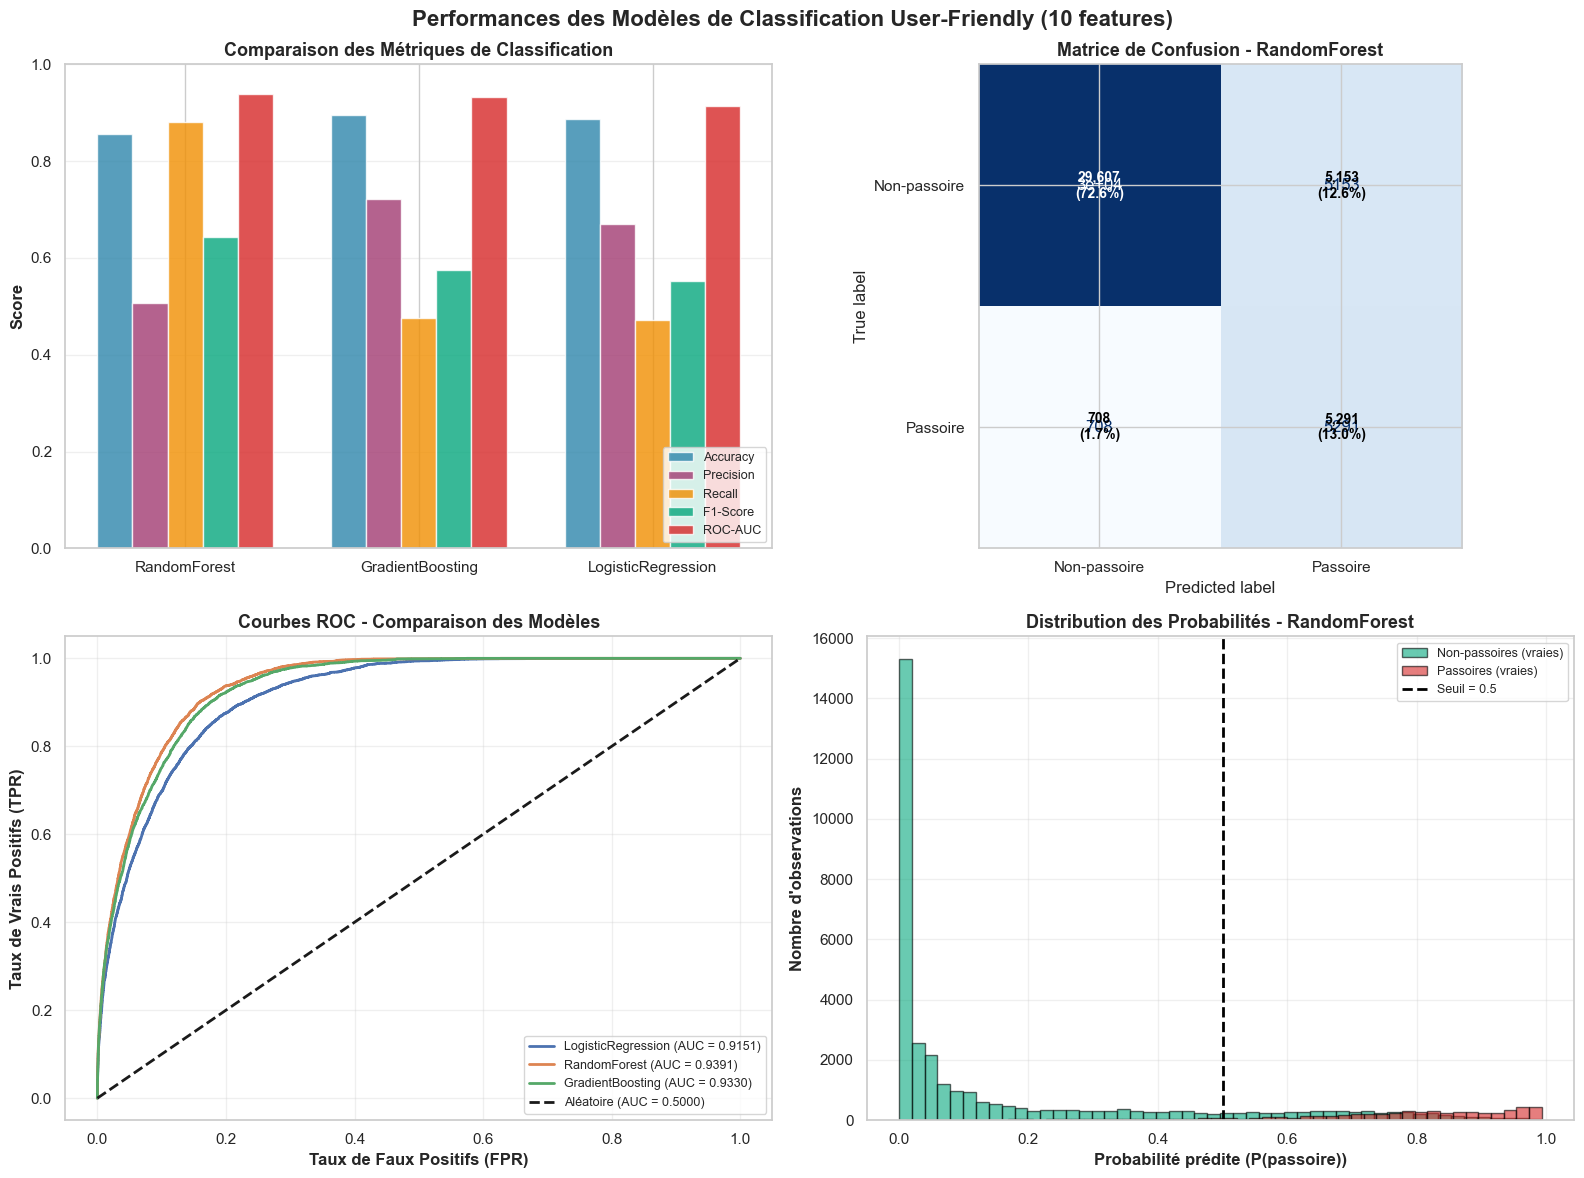


‚úÖ Visualisations g√©n√©r√©es avec succ√®s


In [88]:
# ========================================
# VISUALISATION DES PERFORMANCES CLASSIFICATION
# ========================================

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Performances des Mod√®les de Classification User-Friendly (10 features)', 
             fontsize=16, fontweight='bold')

# 1. Comparaison des m√©triques en barres group√©es
ax1 = axes[0, 0]
x = np.arange(len(results_clf_df))
width = 0.15

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
colors_metrics = ['#2E86AB', '#A23B72', '#F18F01', '#06A77D', '#D62828']

for i, metric in enumerate(metrics):
    offset = width * (i - 2)
    bars = ax1.bar(x + offset, results_clf_df[metric], width, 
                   label=metric, color=colors_metrics[i], alpha=0.8)

ax1.set_ylabel('Score', fontsize=12, fontweight='bold')
ax1.set_title('Comparaison des M√©triques de Classification', fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(results_clf_df['Mod√®le'], fontsize=11)
ax1.legend(fontsize=9, loc='lower right')
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 1])

# 2. Matrice de confusion du meilleur mod√®le
ax2 = axes[0, 1]
best_model_name = results_clf_df.iloc[0]['Mod√®le']
y_pred_best = results_classification_user[best_model_name]['y_pred_test']

cm = confusion_matrix(y_test_clf_user, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-passoire', 'Passoire'])
disp.plot(ax=ax2, cmap='Blues', colorbar=False)
ax2.set_title(f'Matrice de Confusion - {best_model_name}', fontsize=13, fontweight='bold')

# Ajouter des annotations
for i in range(2):
    for j in range(2):
        text_color = 'white' if cm[i, j] > cm.max() / 2 else 'black'
        ax2.text(j, i, f'{cm[i, j]:,}\n({cm[i, j]/cm.sum()*100:.1f}%)',
                ha='center', va='center', color=text_color, fontsize=10, fontweight='bold')

# 3. Courbes ROC pour les 3 mod√®les
ax3 = axes[1, 0]

for model_name in results_classification_user.keys():
    y_proba = results_classification_user[model_name]['y_pred_proba_test']
    fpr, tpr, _ = roc_curve(y_test_clf_user, y_proba)
    roc_auc = results_classification_user[model_name]['roc_auc']
    
    ax3.plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC = {roc_auc:.4f})')

ax3.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Al√©atoire (AUC = 0.5000)')
ax3.set_xlabel('Taux de Faux Positifs (FPR)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Taux de Vrais Positifs (TPR)', fontsize=12, fontweight='bold')
ax3.set_title('Courbes ROC - Comparaison des Mod√®les', fontsize=13, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(alpha=0.3)

# 4. Distribution des probabilit√©s pr√©dites (meilleur mod√®le)
ax4 = axes[1, 1]
y_proba_best = results_classification_user[best_model_name]['y_pred_proba_test']

# S√©parer les probabilit√©s selon la vraie classe
proba_non_passoire = y_proba_best[y_test_clf_user == 0]
proba_passoire = y_proba_best[y_test_clf_user == 1]

ax4.hist(proba_non_passoire, bins=50, alpha=0.6, label='Non-passoires (vraies)', 
         color='#06A77D', edgecolor='black')
ax4.hist(proba_passoire, bins=50, alpha=0.6, label='Passoires (vraies)', 
         color='#D62828', edgecolor='black')

ax4.axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Seuil = 0.5')
ax4.set_xlabel('Probabilit√© pr√©dite (P(passoire))', fontsize=12, fontweight='bold')
ax4.set_ylabel('Nombre d\'observations', fontsize=12, fontweight='bold')
ax4.set_title(f'Distribution des Probabilit√©s - {best_model_name}', fontsize=13, fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n‚úÖ Visualisations g√©n√©r√©es avec succ√®s")

### 4.4 Importance des features pour la classification


IMPORTANCE DES FEATURES POUR LA CLASSIFICATION


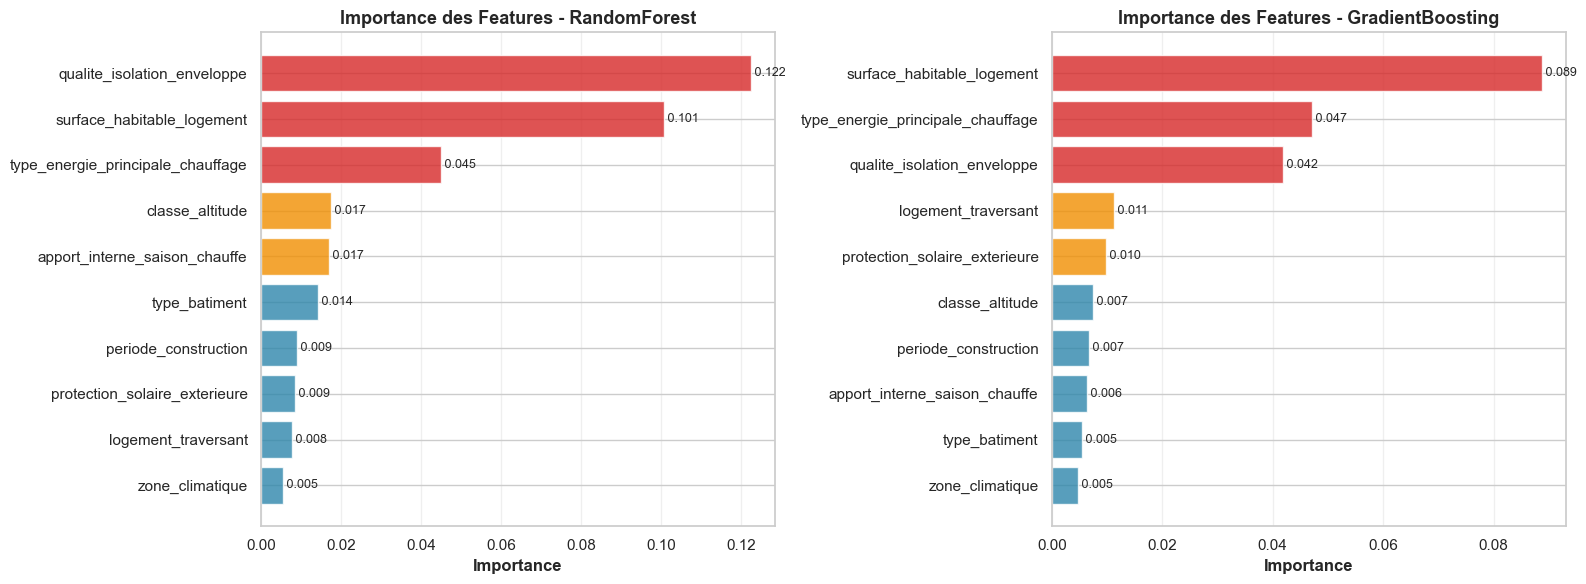


‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
TOP 5 FEATURES - RandomForest
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
  qualite_isolation_enveloppe              : 0.1224
  surface_habitable_logement               : 0.1007
  type_energie_principale_chauffage        : 0.0451
  classe_altitude                          : 0.0175
  apport_interne_saison_chauffe            : 0.0171

‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚

In [89]:
# ========================================
# IMPORTANCE DES FEATURES (CLASSIFICATION)
# ========================================

print("\n" + "="*80)
print("IMPORTANCE DES FEATURES POUR LA CLASSIFICATION")
print("="*80)

# Analyser pour RandomForest et GradientBoosting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, model_name in enumerate(['RandomForest', 'GradientBoosting']):
    if model_name in results_classification_user:
        ax = axes[idx]
        
        # R√©cup√©rer le mod√®le entra√Æn√©
        best_model = results_classification_user[model_name]['best_model']
        
        # Extraire le mod√®le de classification du pipeline
        clf_model = best_model.named_steps['model']
        
        # Obtenir les importances
        importances = clf_model.feature_importances_
        
        # Obtenir les noms des features apr√®s preprocessing
        # Pour simplifier, on utilise les features d'origine
        feature_names = available_user_features
        
        # Cr√©er un DataFrame
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances[:len(feature_names)]
        }).sort_values('Importance', ascending=False)
        
        # Graphique
        colors = ['#D62828' if i < 3 else '#F18F01' if i < 5 else '#2E86AB' 
                  for i in range(len(importance_df))]
        
        ax.barh(importance_df['Feature'], importance_df['Importance'], color=colors, alpha=0.8)
        ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
        ax.set_title(f'Importance des Features - {model_name}', fontsize=13, fontweight='bold')
        ax.invert_yaxis()
        ax.grid(axis='x', alpha=0.3)
        
        # Ajouter les valeurs
        for i, (feat, imp) in enumerate(zip(importance_df['Feature'], importance_df['Importance'])):
            ax.text(imp, i, f' {imp:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Afficher le top 5 pour chaque mod√®le
for model_name in ['RandomForest', 'GradientBoosting']:
    if model_name in results_classification_user:
        print(f"\n{'‚îÄ'*80}")
        print(f"TOP 5 FEATURES - {model_name}")
        print(f"{'‚îÄ'*80}")
        
        best_model = results_classification_user[model_name]['best_model']
        clf_model = best_model.named_steps['model']
        importances = clf_model.feature_importances_
        
        importance_df = pd.DataFrame({
            'Feature': available_user_features,
            'Importance': importances[:len(available_user_features)]
        }).sort_values('Importance', ascending=False)
        
        for i, row in importance_df.head(5).iterrows():
            print(f"  {row['Feature']:40s} : {row['Importance']:.4f}")

print(f"\n{'='*80}")
print("üí° CONCLUSION : Les m√™mes features importantes en r√©gression")
print("   sont aussi importantes pour la classification des passoires.")
print("="*80)

### 4.5 Synth√®se finale : Mod√®les User-Friendly pour la Webapp

In [90]:
# ========================================
# SYNTH√àSE FINALE : MOD√àLES POUR LA WEBAPP
# ========================================

print("\n" + "="*80)
print("R√âCAPITULATIF COMPLET - MOD√àLES USER-FRIENDLY (10 FEATURES)")
print("="*80)

print(f"\nüìã FEATURES UTILIS√âES ({len(available_user_features)}) :")
print("‚îÄ"*80)
for i, feat in enumerate(available_user_features, 1):
    print(f"  {i:2d}. {feat}")

print(f"\n\n{'='*80}")
print("R√âGRESSION : Pr√©diction de la consommation √©nerg√©tique")
print("="*80)

# Meilleur mod√®le de r√©gression
best_reg_model = max(results_user.keys(), key=lambda k: results_user[k]['r2_test'])
best_reg_r2 = results_user[best_reg_model]['r2_test']
best_reg_rmse = results_user[best_reg_model]['rmse_test']

print(f"\nüèÜ Meilleur mod√®le : {best_reg_model}")
print(f"   ‚Ä¢ R¬≤ Score         : {best_reg_r2:.4f} ({best_reg_r2*100:.1f}% de variance expliqu√©e)")
print(f"   ‚Ä¢ RMSE             : {best_reg_rmse:,.2f} kWh/m¬≤/an")
print(f"   ‚Ä¢ MAE              : {results_user[best_reg_model]['mae_test']:,.2f} kWh/m¬≤/an")

# Comparaison avec mod√®le complet
full_reg_r2 = results_regression[best_reg_model]['r2']
retention = (best_reg_r2 / full_reg_r2) * 100
print(f"\n   ‚úì R√©tention vs mod√®le complet (36f) : {retention:.1f}%")

print(f"\n\n{'='*80}")
print("CLASSIFICATION : Pr√©diction des passoires √©nerg√©tiques (DPE F/G)")
print("="*80)

# Meilleur mod√®le de classification
best_clf_model = max(results_classification_user.keys(), 
                     key=lambda k: results_classification_user[k]['roc_auc'])
best_clf_auc = results_classification_user[best_clf_model]['roc_auc']
best_clf_f1 = results_classification_user[best_clf_model]['f1_score']

print(f"\nüèÜ Meilleur mod√®le : {best_clf_model}")
print(f"   ‚Ä¢ ROC-AUC          : {best_clf_auc:.4f}")
print(f"   ‚Ä¢ F1-Score         : {best_clf_f1:.4f}")
print(f"   ‚Ä¢ Accuracy         : {results_classification_user[best_clf_model]['accuracy']:.4f}")
print(f"   ‚Ä¢ Precision        : {results_classification_user[best_clf_model]['precision']:.4f}")
print(f"   ‚Ä¢ Recall           : {results_classification_user[best_clf_model]['recall']:.4f}")

print(f"\n\n{'='*80}")
print("RECOMMANDATIONS POUR LE D√âPLOIEMENT WEBAPP")
print("="*80)

print(f"\n‚úÖ MOD√àLES VALID√âS POUR PRODUCTION")
print(f"\n1Ô∏è‚É£  R√âGRESSION (pr√©diction consommation) :")
print(f"    ‚Üí Mod√®le : {best_reg_model}")
print(f"    ‚Üí Performance : R¬≤ = {best_reg_r2:.4f}, RMSE = {best_reg_rmse:,.0f} kWh/m¬≤/an")
print(f"    ‚Üí Usage : Estimer la consommation √©nerg√©tique annuelle")

print(f"\n2Ô∏è‚É£  CLASSIFICATION (d√©tection passoires) :")
print(f"    ‚Üí Mod√®le : {best_clf_model}")
print(f"    ‚Üí Performance : ROC-AUC = {best_clf_auc:.4f}, F1 = {best_clf_f1:.4f}")
print(f"    ‚Üí Usage : Identifier si le logement est une passoire (DPE F ou G)")

print(f"\nüìù EXP√âRIENCE UTILISATEUR WEBAPP :")
print(f"    ‚Ä¢ Nombre de questions    : 5-7 (3 auto-calcul√©es)")
print(f"    ‚Ä¢ Temps de saisie estim√© : ~2 minutes")
print(f"    ‚Ä¢ Variables auto-d√©riv√©es :")
print(f"      - zone_climatique        ‚Üí depuis code postal")
print(f"      - classe_altitude        ‚Üí depuis code postal")
print(f"      - apport_interne...      ‚Üí surface √ó 15")

print(f"\nüíæ PROCHAINES √âTAPES :")
print(f"    1. Sauvegarder les mod√®les (joblib.dump)")
print(f"    2. Cr√©er les fonctions de preprocessing")
print(f"    3. D√©velopper l'API Flask/FastAPI")
print(f"    4. Int√©grer dans l'interface web")

print(f"\n{'='*80}")
print("‚úÖ ANALYSE TERMIN√âE - MOD√àLES PR√äTS POUR LA WEBAPP")
print("="*80)


R√âCAPITULATIF COMPLET - MOD√àLES USER-FRIENDLY (10 FEATURES)

üìã FEATURES UTILIS√âES (10) :
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
   1. surface_habitable_logement
   2. periode_construction
   3. type_batiment
   4. qualite_isolation_enveloppe
   5. type_energie_principale_chauffage
   6. logement_traversant
   7. protection_solaire_exterieure
   8. zone_climatique
   9. classe_altitude
  10. apport_interne_saison_chauffe


R√âGRESSION : Pr√©diction de la consommation √©nerg√©tique

üèÜ Meilleur mod√®le : GradientBoosting
   ‚Ä¢ R¬≤ Score         : 0.9127 (91.3% de variance expliqu√©e)
   ‚Ä¢ RMSE             : 16,359.65 kWh/m¬≤/an
   ‚Ä¢ MAE              : 5,075.47 kWh/m¬≤/an

   ‚úì R√©tention vs mod√®le complet (36f) : 99.4%


CLASSIFICATION : Pr√©diction des passoires √©nerg√©t

## Partie 5 : Sauvegarde des Mod√®les pour la Webapp

Les mod√®les user-friendly (10 features) ont √©t√© valid√©s et sont pr√™ts pour le d√©ploiement.
Nous allons maintenant les sauvegarder pour utilisation dans la webapp.

In [91]:
# ========================================
# SAUVEGARDE DES MOD√àLES POUR LA WEBAPP
# ========================================

import joblib
from datetime import datetime

# Cr√©er un timestamp pour versionner les mod√®les
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

print("\n" + "="*80)
print("SAUVEGARDE DES MOD√àLES USER-FRIENDLY")
print("="*80)

# Cr√©er le dossier de sauvegarde
import os
models_dir = "models_pkl"
os.makedirs(models_dir, exist_ok=True)

print(f"\nüìÅ Dossier de sauvegarde : {models_dir}/")

# 1. Sauvegarder le meilleur mod√®le de R√âGRESSION
best_reg_model_name = max(results_user.keys(), key=lambda k: results_user[k]['r2_test'])
best_reg_model = results_user[best_reg_model_name]['best_model']
best_reg_r2 = results_user[best_reg_model_name]['r2_test']
best_reg_rmse = results_user[best_reg_model_name]['rmse_test']

reg_filename = f"{models_dir}/regression_{best_reg_model_name.lower()}_{timestamp}.pkl"
joblib.dump(best_reg_model, reg_filename)

print(f"\n‚úÖ R√âGRESSION sauvegard√©e :")
print(f"   ‚Ä¢ Mod√®le   : {best_reg_model_name}")
print(f"   ‚Ä¢ R¬≤       : {best_reg_r2:.4f}")
print(f"   ‚Ä¢ RMSE     : {best_reg_rmse:,.2f} kWh/m¬≤/an")
print(f"   ‚Ä¢ Fichier  : {reg_filename}")

# 2. Sauvegarder le meilleur mod√®le de CLASSIFICATION
best_clf_model_name = max(results_classification_user.keys(), 
                          key=lambda k: results_classification_user[k]['roc_auc'])
best_clf_model = results_classification_user[best_clf_model_name]['best_model']
best_clf_auc = results_classification_user[best_clf_model_name]['roc_auc']
best_clf_f1 = results_classification_user[best_clf_model_name]['f1_score']

clf_filename = f"{models_dir}/classification_{best_clf_model_name.lower()}_{timestamp}.pkl"
joblib.dump(best_clf_model, clf_filename)

print(f"\n‚úÖ CLASSIFICATION sauvegard√©e :")
print(f"   ‚Ä¢ Mod√®le   : {best_clf_model_name}")
print(f"   ‚Ä¢ ROC-AUC  : {best_clf_auc:.4f}")
print(f"   ‚Ä¢ F1-Score : {best_clf_f1:.4f}")
print(f"   ‚Ä¢ Fichier  : {clf_filename}")

# 3. Sauvegarder les m√©tadonn√©es (features utilis√©es, etc.)
metadata = {
    'timestamp': timestamp,
    'features': available_user_features,
    'n_features': len(available_user_features),
    'regression': {
        'model_name': best_reg_model_name,
        'r2_score': float(best_reg_r2),
        'rmse': float(best_reg_rmse),
        'mae': float(results_user[best_reg_model_name]['mae_test']),
        'target': 'conso_5_usages_ep'
    },
    'classification': {
        'model_name': best_clf_model_name,
        'roc_auc': float(best_clf_auc),
        'f1_score': float(best_clf_f1),
        'accuracy': float(results_classification_user[best_clf_model_name]['accuracy']),
        'precision': float(results_classification_user[best_clf_model_name]['precision']),
        'recall': float(results_classification_user[best_clf_model_name]['recall']),
        'target': 'passoire'
    },
    'preprocessing': {
        'numeric_features': user_numeric,
        'categorical_features': user_categorical
    }
}

metadata_filename = f"{models_dir}/metadata_{timestamp}.pkl"
joblib.dump(metadata, metadata_filename)

print(f"\n‚úÖ M√âTADONN√âES sauvegard√©es :")
print(f"   ‚Ä¢ Fichier : {metadata_filename}")
print(f"   ‚Ä¢ Contenu : Features, performances, configuration")

print(f"\n{'='*80}")
print(f"üíæ SAUVEGARDE TERMIN√âE")
print(f"{'='*80}")
print(f"\nüì¶ Fichiers cr√©√©s :")
print(f"   1. {reg_filename}")
print(f"   2. {clf_filename}")
print(f"   3. {metadata_filename}")

print(f"\nüí° Exemple d'int√©gration :")
print(f"""
import joblib

# Charger les mod√®les
model_reg = joblib.load('{reg_filename}')
model_clf = joblib.load('{clf_filename}')
metadata = joblib.load('{metadata_filename}')

# Faire une pr√©diction
# prediction_conso = model_reg.predict(X_new)
# prediction_passoire = model_clf.predict(X_new)
""")


SAUVEGARDE DES MOD√àLES USER-FRIENDLY

üìÅ Dossier de sauvegarde : models_pkl/

‚úÖ R√âGRESSION sauvegard√©e :
   ‚Ä¢ Mod√®le   : GradientBoosting
   ‚Ä¢ R¬≤       : 0.9127
   ‚Ä¢ RMSE     : 16,359.65 kWh/m¬≤/an
   ‚Ä¢ Fichier  : models_pkl/regression_gradientboosting_20251031_011714.pkl

‚úÖ CLASSIFICATION sauvegard√©e :
   ‚Ä¢ Mod√®le   : RandomForest
   ‚Ä¢ ROC-AUC  : 0.9391
   ‚Ä¢ F1-Score : 0.6436
   ‚Ä¢ Fichier  : models_pkl/classification_randomforest_20251031_011714.pkl

‚úÖ M√âTADONN√âES sauvegard√©es :
   ‚Ä¢ Fichier : models_pkl/metadata_20251031_011714.pkl
   ‚Ä¢ Contenu : Features, performances, configuration

üíæ SAUVEGARDE TERMIN√âE

üì¶ Fichiers cr√©√©s :
   1. models_pkl/regression_gradientboosting_20251031_011714.pkl
   2. models_pkl/classification_randomforest_20251031_011714.pkl
   3. models_pkl/metadata_20251031_011714.pkl

üí° Exemple d'int√©gration :

import joblib

# Charger les mod√®les
model_reg = joblib.load('models_pkl/regression_gradientboosting_202510

### R√©capitulatif Final

In [94]:
# ========================================
# R√âCAPITULATIF FINAL DU PROJET
# ========================================

print("\n" + "="*80)
print("R√âSUM√â COMPLET DU PROJET - PR√âDICTION DPE HAUTE-SAVOIE")
print("="*80)

print(f"""
üìä DATASET
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
  ‚Ä¢ Source            : logements_74.csv
  ‚Ä¢ Observations      : {len(df_work):,} logements en Haute-Savoie
  ‚Ä¢ Variables totales : 236 colonnes initiales
  ‚Ä¢ Features finales  : {len(available_user_features)} variables user-friendly

üìã FEATURES S√âLECTIONN√âES (10 variables)
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
""")

for i, feat in enumerate(available_user_features, 1):
    print(f"  {i:2d}. {feat}")

print(f"""

üéØ MOD√àLES D√âVELOPP√âS
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

1Ô∏è‚É£  R√âGRESSION : Pr√©diction de la consommation √©nerg√©tique
    Target           : conso_5_usages_ep (kWh/m¬≤/an)
    Meilleur mod√®le  : {best_reg_model_name}
    Performance      : R¬≤ = {best_reg_r2:.4f} (variance expliqu√©e : {best_reg_r2*100:.1f}%)
                       RMSE = {best_reg_rmse:,.2f} kWh/m¬≤/an
                       MAE = {results_user[best_reg_model_name]['mae_test']:,.2f} kWh/m¬≤/an
    
    ‚úì R√©tention vs mod√®le complet (36f) : {(best_reg_r2 / results_regression[best_reg_model_name]['r2'])*100:.1f}%

2Ô∏è‚É£  CLASSIFICATION : D√©tection des passoires √©nerg√©tiques (DPE F/G)
    Target           : passoire (0=Non, 1=Oui)
    Meilleur mod√®le  : {best_clf_model_name}
    Performance      : ROC-AUC = {best_clf_auc:.4f}
                       F1-Score = {best_clf_f1:.4f}
                       Accuracy = {results_classification_user[best_clf_model_name]['accuracy']:.4f}
                       Precision = {results_classification_user[best_clf_model_name]['precision']:.4f}
                       Recall = {results_classification_user[best_clf_model_name]['recall']:.4f}

üíæ SAUVEGARDE
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
  ‚Ä¢ Dossier         : {models_dir}
  ‚Ä¢ Mod√®le r√©gression    : ‚úÖ Sauvegard√©
  ‚Ä¢ Mod√®le classification : ‚úÖ Sauvegard√©
  ‚Ä¢ M√©tadonn√©es     : ‚úÖ Sauvegard√©es

""")

print("="*80)
print("‚úÖ PROJET TERMIN√â")
print("="*80)



R√âSUM√â COMPLET DU PROJET - PR√âDICTION DPE HAUTE-SAVOIE

üìä DATASET
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
  ‚Ä¢ Source            : logements_74.csv
  ‚Ä¢ Observations      : 203,792 logements en Haute-Savoie
  ‚Ä¢ Variables totales : 236 colonnes initiales
  ‚Ä¢ Features finales  : 10 variables user-friendly

üìã FEATURES S√âLECTIONN√âES (10 variables)
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

   1. surface_habitable_logement
   2. periode_construction
   3. type_batiment
   4. qualite_isolation_enveloppe
   5. type_energie_principale_chauffage
   6. logement_traversant
   7. protection_solaire_